# Comparison between "Comprehensive upper-air observation network from 1905 to present" and "Insitu IGRA radiosoundings baseline network"

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to find differences in both mentioned data sets and to compare them. 

    Author: U. Voggenberger
    Date: 10.2020
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2020


In [1]:
import pandas
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 24,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [3]:
def request(rqdict, source):
    t0 = time.time()

    c = cdsapi.Client()
    r = c.retrieve(
        source,rqdict)
    if True:
        r.download(target='download.zip')
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./test/')
    z.close()
    
    files = glob.glob('./test/*.nc')
    
    if files[0].split('/')[-1].startswith('IGRA'):
        ds = xarray.open_dataset(files[0])            
        data = ds.to_dataframe()

    else:
        ds = xarray.open_dataset(files[0])            
        to_be_removed = ['trajectory_index', 'trajectory']
        for ivar in list(ds.variables):
            if 'string' in ivar:
                to_be_removed.append(ivar)

            if 'trajectory' in ds[ivar].dims and ivar not in list(ds.coords):
                report_id = ds[ivar].astype(object).sum(axis=1).astype(str)
                ds = ds.drop_vars(ivar)
                ds[ivar] = ('obs', report_id.values[ds.trajectory_index.values])  # todo obs ???

            if ds[ivar].ndim > 1:
                tmp= ds[ivar].astype(object).sum(axis=1).astype(str)
                ds = ds.drop_vars(ivar)
                idim = tmp.dims[0]
                ds[ivar] = (idim, tmp)

        ds = ds.drop_vars(to_be_removed)
        data = ds.to_dataframe()
    
    os.remove('download.zip')
    try:
       shutil.rmtree('./test/')
    except:
       print('Error while deleting directory')
    
    return data

---

# Analyzing and comparing temperature values for IGRA (and its harmonized version) and Comprehensive upper-air observation network (COMP)
# Vienna 11035

In [4]:
loc = '11035 Vienna'

---

## Loading Data:

All data has been downloaded via the cds-api in a similar manner like depicted in 'IGRA_Comparison_Request.ipyn'. 

In [5]:
comp = 'insitu-comprehensive-upper-air-observation-network'
igra = 'insitu-observations-igra-baseline-network'

In [6]:
request({
            'variable': 'temperature',
            'statid': '11035',
            'date': '20000101-20100101',
        }, comp)

/jetfs/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.3.1/miniconda3-4.8.2-3m7b6t2kgedyr3jnd2nasmgiq7wm27iv/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-01-29 13:27:35,457 INFO Welcome to the CDS
2021-01-29 13:27:35,459 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
/jetfs/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.3.1/miniconda3-4.8.2-3m7b6t2kgedyr3jnd2nasmgiq7wm27iv/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/ad

lat        lon     plev          ta                time  \
obs                                                              
0    48.23  16.370001    590.0  211.300003 2000-01-01 00:00:00   
0    48.23  16.370001    760.0  206.500000 2000-01-01 00:00:00   
0    48.23  16.370001   1000.0  205.899994 2000-01-01 00:00:00   
0    48.23  16.370001   1190.0  205.899994 2000-01-01 00:00:00   
0    48.23  16.370001   1320.0  202.500000 2000-01-01 00:00:00   
..     ...        ...      ...         ...                 ...   
0    48.25  16.370001  92500.0  278.399994 2010-01-01 12:00:00   
0    48.25  16.370001  94600.0  279.799988 2010-01-01 12:00:00   
0    48.25  16.370001  95300.0  279.799988 2010-01-01 12:00:00   
0    48.25  16.370001  95400.0  279.000000 2010-01-01 12:00:00   
0    48.25  16.370001  95800.0  278.399994 2010-01-01 12:00:00   

    trajectory_label  
obs                   
0        10000030636  
0        10000030636  
0        10000030636  
0        10000030636  
0        10000030636  
..               ...  
0        10000045411  
0        10000045411  
0        10000045411  
0        10000045411  
0        10000045411  

[443662 rows x 6 columns]

In [7]:
request(
    {
        'source': 'IGRA_H',
        'variable': ['air_temperature'],
        'station_name': ['AUM00011035'],
        'period': '2000-01-01/2010-01-01',
    }, igra)

/jetfs/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.3.1/miniconda3-4.8.2-3m7b6t2kgedyr3jnd2nasmgiq7wm27iv/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-01-29 13:27:36,988 INFO Welcome to the CDS
2021-01-29 13:27:36,989 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
/jetfs/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.3.1/miniconda3-4.8.2-3m7b6t2kgedyr3jnd2nasmgiq7wm27iv/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-us

station_name report_timestamp             actual_time  report_id  \
index                                                                     
0       AUM00011035       2000-01-02  2000-01-01 23:30:00+00    9443102   
1       AUM00011035       2000-01-02  2000-01-01 23:30:00+00    9443102   
2       AUM00011035       2000-01-02  2000-01-01 23:30:00+00    9443102   
3       AUM00011035       2000-01-02  2000-01-01 23:30:00+00    9443102   
4       AUM00011035       2000-01-02  2000-01-01 23:30:00+00    9443102   
...             ...              ...                     ...        ...   
411204  AUM00011035       2010-01-01  2009-12-31 23:30:00+00    9438882   
411205  AUM00011035       2010-01-01  2009-12-31 23:30:00+00    9438882   
411206  AUM00011035       2010-01-01  2009-12-31 23:30:00+00    9438882   
411207  AUM00011035       2010-01-01  2009-12-31 23:30:00+00    9438882   
411208  AUM00011035       2010-01-01  2009-12-31 23:30:00+00    9438882   

        longitude  latitude  height_of_station_above_sea_level  air_pressure  \
index                                                                          
0         16.3564   48.2486                                200         20900   
1         16.3564   48.2486                                200         93800   
2         16.3564   48.2486                                200          2470   
3         16.3564   48.2486                                200          7930   
4         16.3564   48.2486                                200         13200   
...           ...       ...                                ...           ...   
411204    16.3564   48.2486                                200          4880   
411205    16.3564   48.2486                                200          1000   
411206    16.3564   48.2486                                200         77800   
411207    16.3564   48.2486                                200         24400   
411208    16.3564   48.2486                                200         97000   

        air_temperature  
index                    
0            214.850006  
1            271.450012  
2            204.759995  
3            211.699997  
4            214.919998  
...                 ...  
411204       212.580002  
411205       224.389999  
411206       269.750000  
411207       212.149994  
411208       276.149994  

[411209 rows x 9 columns]

In [36]:
files = glob.glob('IGRA_10393/*/*.csv')
files_h = glob.glob('IGRA_H_10393/*/*.csv')
print(len(files) == len(files_h))

True


In [5]:
# IGRA and its harmonized version
for i in range(len(files)):
    if i == 0:
        igra = pandas.read_csv(files[i], header=12)
        igrah = pandas.read_csv(files_h[i], header=12)
    else:
        igra = igra.append(pandas.read_csv(files[i], header=12))
        igrah = igrah.append(pandas.read_csv(files_h[i], header=12))

In [6]:
# COMP - Comprehensive upper-air observation network from 1905 to present
files = glob.glob('COMP_10393/*/temperature.csv')
for i in range(len(files)):
    if i == 0:
        comp = pandas.read_csv(files[i])
    else:
        comp = comp.append(pandas.read_csv(files[i]))

In [7]:
comp = comp[comp.time < '2018-10'] # igra data is only available up to Oct.2018, so we shorten the comp data

## Getting the data to the same length for comparison (IGRA_H vs COMP) on 4 standard pressure leveles:
there are more ascents in the COMP data, it will be reduced to only ascents starting at 00:00 and 12:00. <br>
Sometimes the ascents were not exactly at 00:00 or 12:00, but were assigned to those profiles.<br>
In the remaining data there are some points in time, which are not in both datasets - those will be removed too.


In [8]:
igra_h_adjusted = []
comp_adjusted = []
igra_adjusted = []
missing_i = []
missing_c = []
comp_original = []
igrah_original = []
igra_original = []
preslist = [10000, 20000, 50000, 85000,]
for i in preslist:
    print('--- \npressure level: ' + str(i))
    datai = igra[igra.air_pressure == i]
    datai.report_timestamp = pandas.to_datetime(datai.report_timestamp, utc=True)
    igra_original.append(datai)
    datah = igrah[igrah.air_pressure == i]
    datah.report_timestamp = pandas.to_datetime(datah.report_timestamp, utc=True)
    igrah_original.append(datah)
    datac = comp[comp.plev == i]
    comp_original.append(datac)
    datar = (datac[datac.time.str[-8:] == '12:00:00'].append(datac[datac.time.str[-8:] == '00:00:00'])).sort_values('time')
    datar.time = pandas.to_datetime(datar.time, utc=True)
    datac.time = pandas.to_datetime(datac.time, utc=True)

    print('Length of COMP: ' + str(len(datac.time)))
    print('Missing Values of COMP: ' + str(datac.ta.isnull().sum()))
    print('Length of reduced COMP: ' + str(len(datar.time)))
    print('Missing Values of reduced COMP: ' + str(datar.ta.isnull().sum()))
    print('Length of IGRA: ' + str(len(datai.report_timestamp)))
    print('Missing Values of IGRA: ' + str(datai.air_temperature.isnull().sum()))
    print('Length of IGRA_H: ' + str(len(datah.report_timestamp)))
    print('Missing Values of IGRA_H: ' + str(datah.air_temperature.isnull().sum()))
    print('Length difference of reduced COMP to IGRA: ' + str(len(datar.time)-len(datai.report_timestamp)))
    print('Length difference of reduced COMP to IGRA_H: ' + str(len(datar.time)-len(datah.report_timestamp)))
    missingtimes1 = []
    for j in datar.time:
        if len(datah[datah.report_timestamp == j]) <1: # -> checking if timestamp is also in the other dataset
            missingtimes1.append(i)
            datar = datar[datar.time != j] # -> kicking it out, if not
            datac = datac[datac.time != j] # -> kicking it out, if not
    print('Missing Timestamps in IGRA_H relative to reduced COMP: ' + str(len(missingtimes1)))
    missingtimes2 = []
    for j in datah.report_timestamp:
        if len(datar[datar.time == j]) <1: # -> checking if timestamp is also in the other dataset
            missingtimes2.append(i)
            datah = datah[datah.report_timestamp != j] # -> kicking it out, if not
            datai = datai[datai.report_timestamp != j] # -> kicking it out, if not
    print('Missing Timestamps in reduced COMP relative to IGRA_H: ' + str(len(missingtimes2)))
    comp_adjusted.append(datar)
    igra_h_adjusted.append(datah)
    igra_adjusted.append(datai)
    missing_i.append(len(missingtimes2))
    missing_c.append(len(missingtimes1))

--- 
pressure level: 10000


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Length of COMP: 120280
Missing Values of COMP: 0
Length of reduced COMP: 19932
Missing Values of reduced COMP: 0
Length of IGRA: 28335
Missing Values of IGRA: 0
Length of IGRA_H: 28335
Missing Values of IGRA_H: 0
Length difference of reduced COMP to IGRA: -8403
Length difference of reduced COMP to IGRA_H: -8403
Missing Timestamps in IGRA_H relative to reduced COMP: 24
Missing Timestamps in reduced COMP relative to IGRA_H: 8427
--- 
pressure level: 20000


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Length of COMP: 122727
Missing Values of COMP: 0
Length of reduced COMP: 20454
Missing Values of reduced COMP: 0
Length of IGRA: 28962
Missing Values of IGRA: 0
Length of IGRA_H: 28962
Missing Values of IGRA_H: 0
Length difference of reduced COMP to IGRA: -8508
Length difference of reduced COMP to IGRA_H: -8508
Missing Timestamps in IGRA_H relative to reduced COMP: 26
Missing Timestamps in reduced COMP relative to IGRA_H: 8534
--- 
pressure level: 50000


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Length of COMP: 123917
Missing Values of COMP: 0
Length of reduced COMP: 20663
Missing Values of reduced COMP: 0
Length of IGRA: 29214
Missing Values of IGRA: 0
Length of IGRA_H: 29214
Missing Values of IGRA_H: 0
Length difference of reduced COMP to IGRA: -8551
Length difference of reduced COMP to IGRA_H: -8551
Missing Timestamps in IGRA_H relative to reduced COMP: 26
Missing Timestamps in reduced COMP relative to IGRA_H: 8577
--- 
pressure level: 85000


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Length of COMP: 124062
Missing Values of COMP: 0
Length of reduced COMP: 20676
Missing Values of reduced COMP: 0
Length of IGRA: 29236
Missing Values of IGRA: 0
Length of IGRA_H: 29236
Missing Values of IGRA_H: 0
Length difference of reduced COMP to IGRA: -8560
Length difference of reduced COMP to IGRA_H: -8560
Missing Timestamps in IGRA_H relative to reduced COMP: 28
Missing Timestamps in reduced COMP relative to IGRA_H: 8588


## Missing data in the data sets

Now we display the missing data in the datasets, those bars labeled as COMP depict the data which is missing in the COMP data set but is available in the IGRA data set; and vice versa.

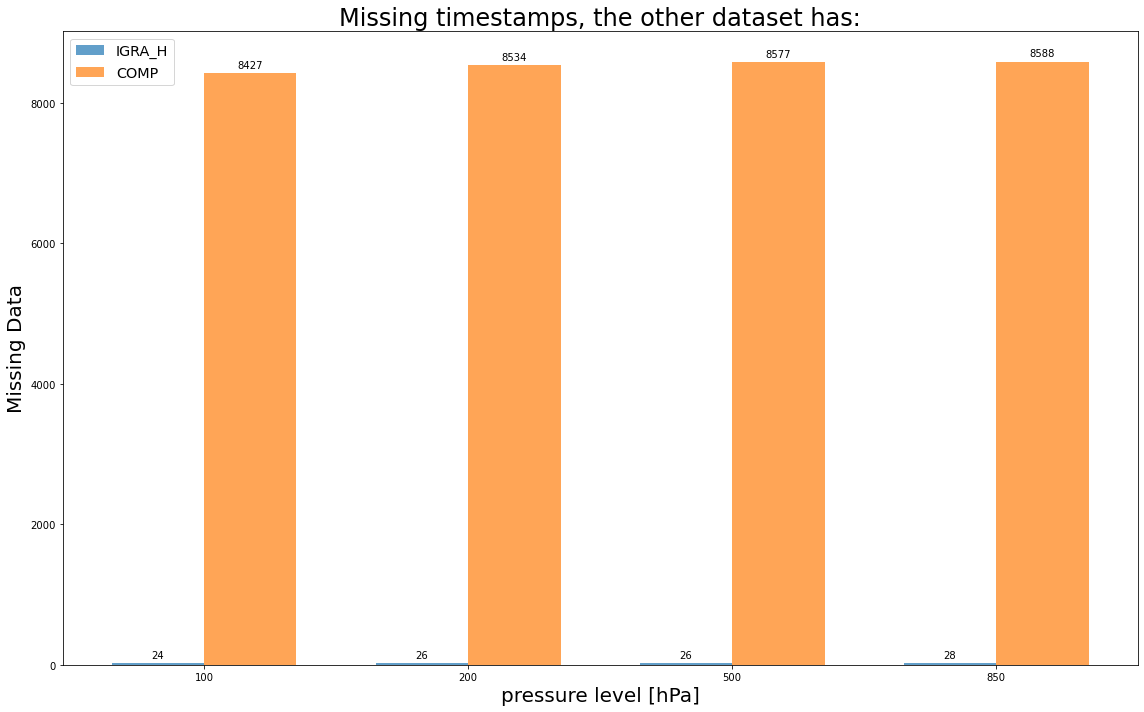

In [9]:
pressl = [100, 200, 500, 850]
x = np.arange(len(pressl))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, missing_c, width, label='IGRA_H', alpha=0.7)
rects2 = ax.bar(x + width/2, missing_i, width, label='COMP', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Missing Data')
ax.set_xlabel('pressure level [hPa]')
ax.set_title('Missing timestamps, the other dataset has:')
ax.set_xticks(x)
ax.set_xticklabels(pressl)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

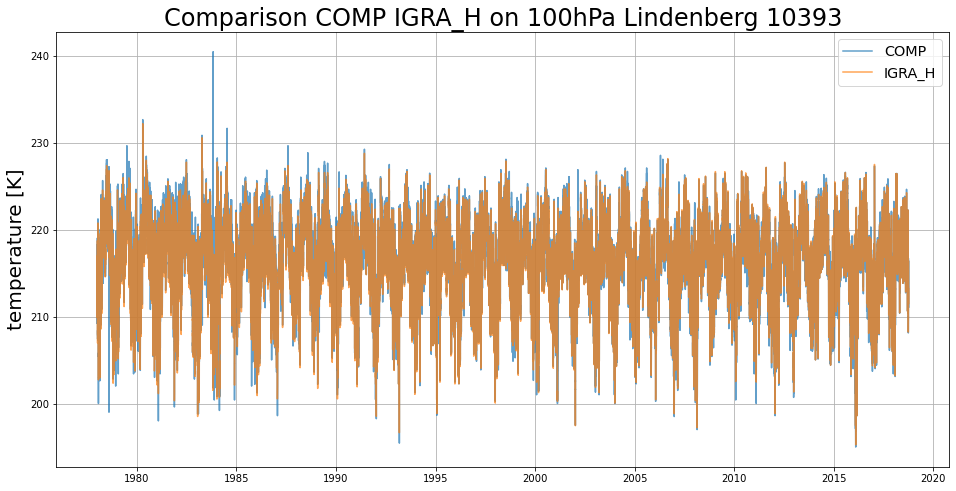

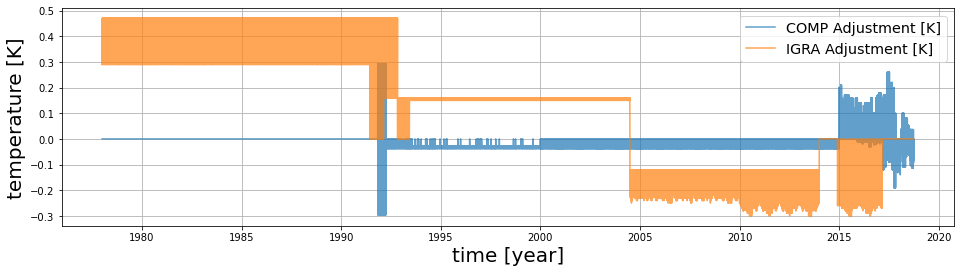

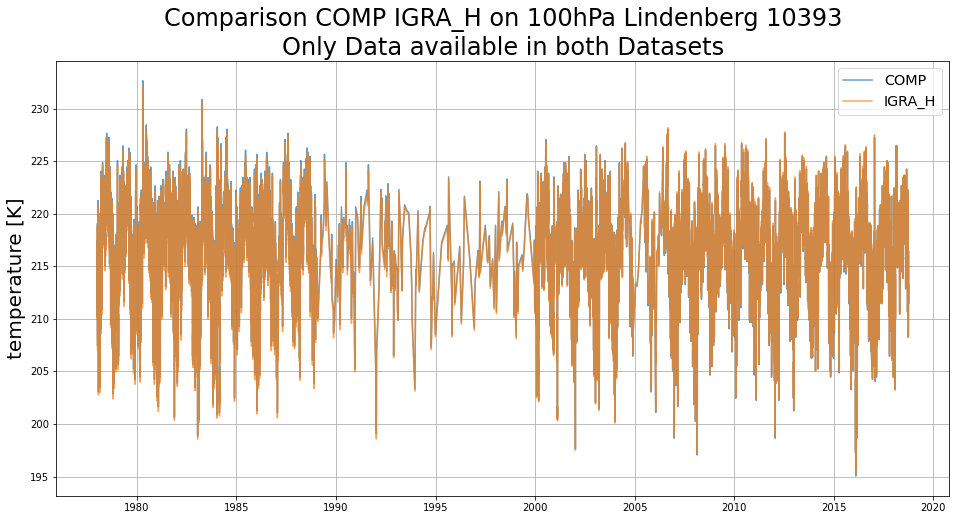

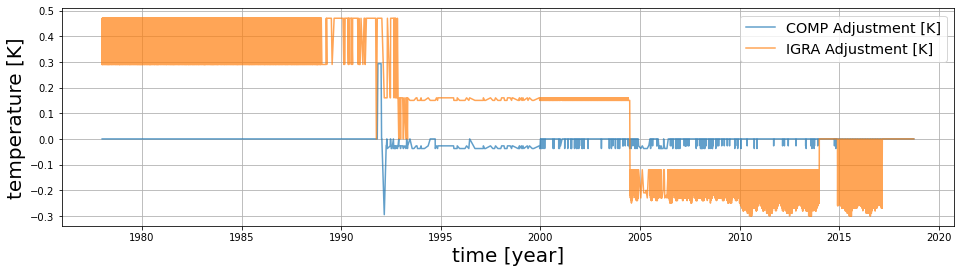

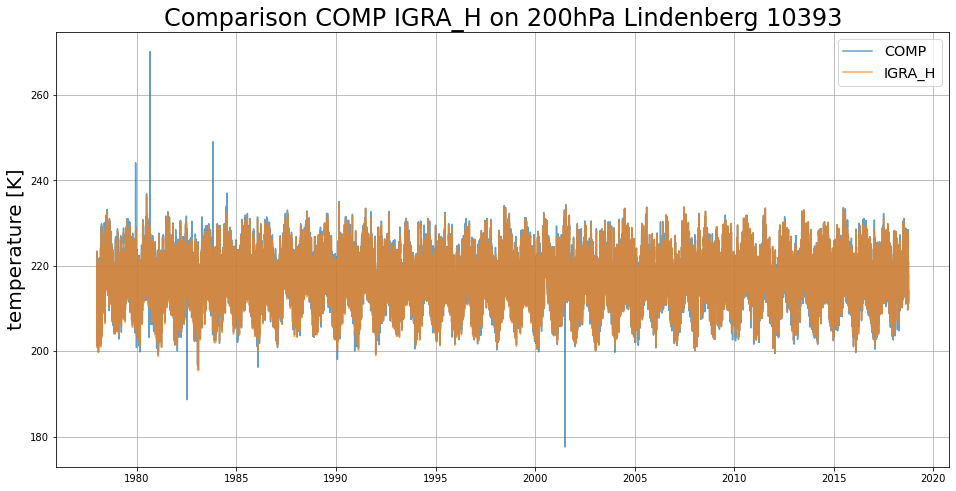

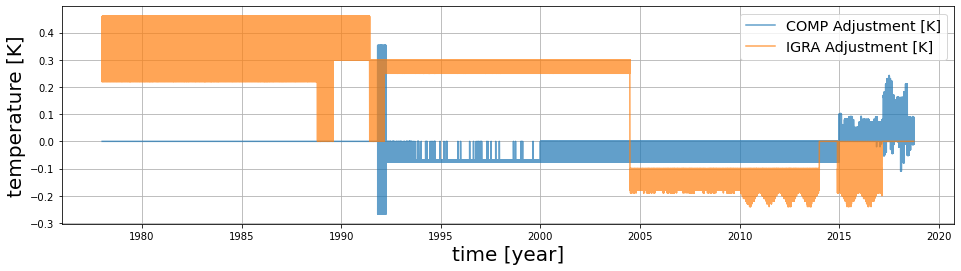

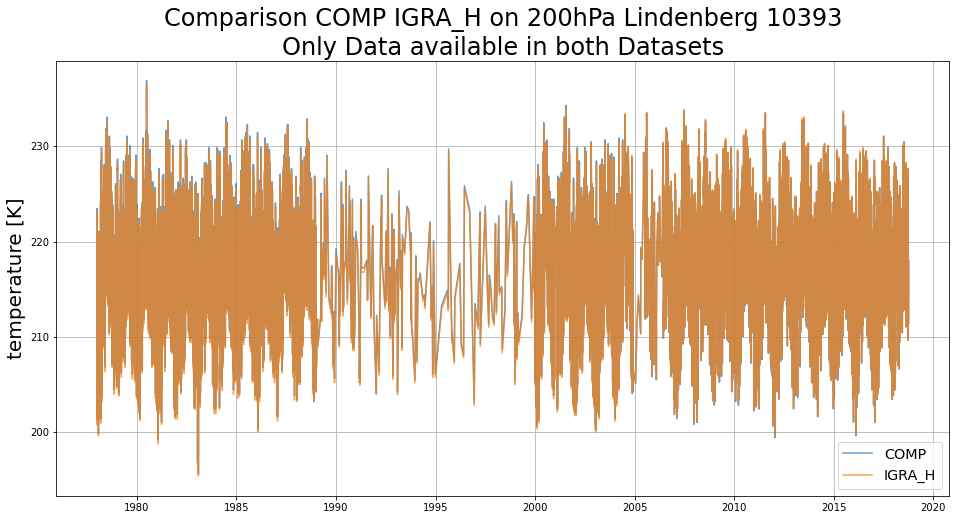

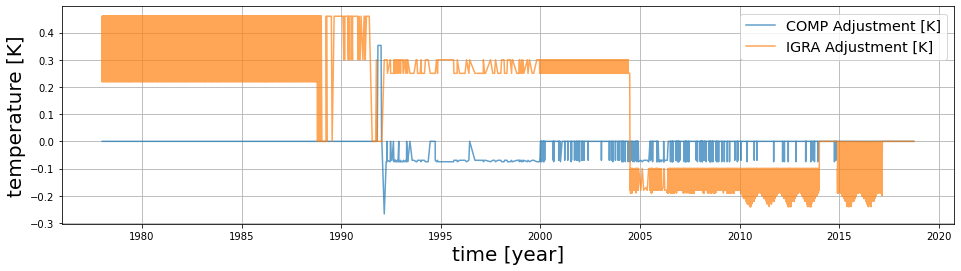

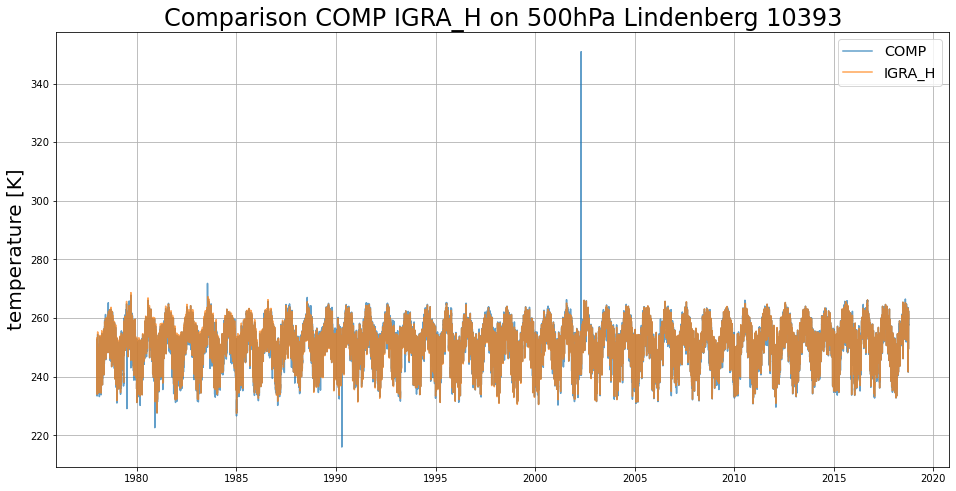

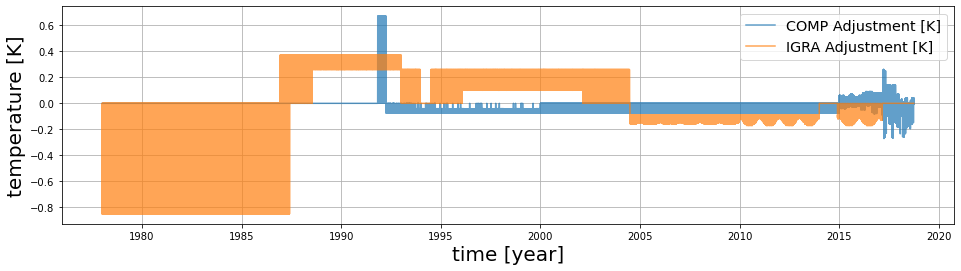

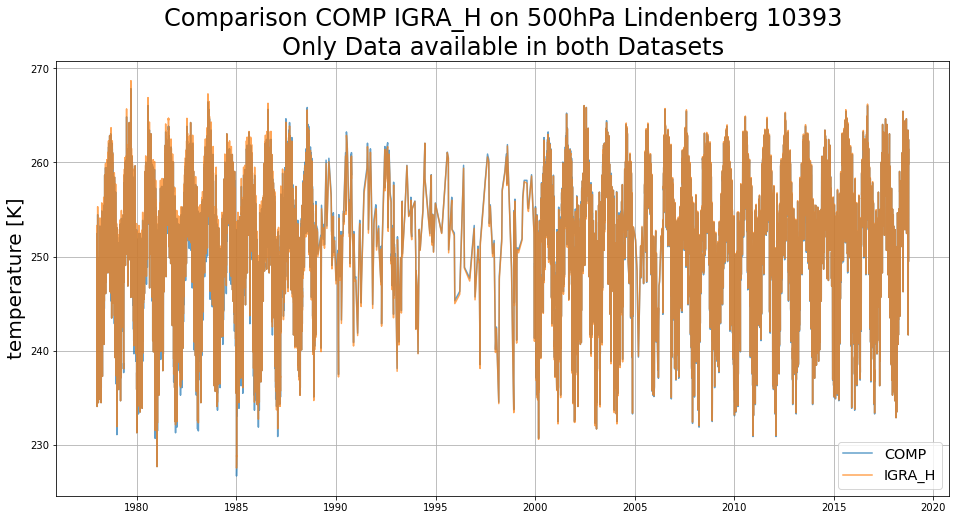

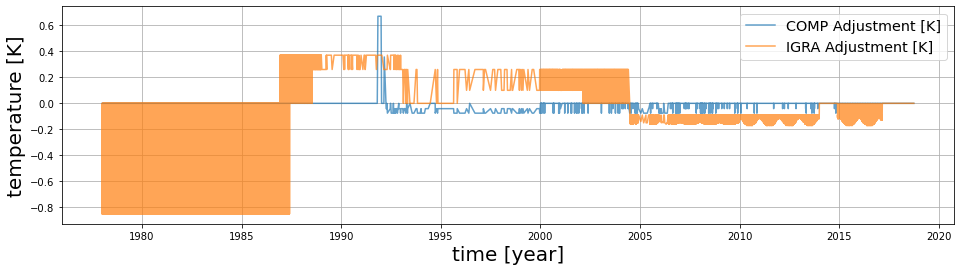

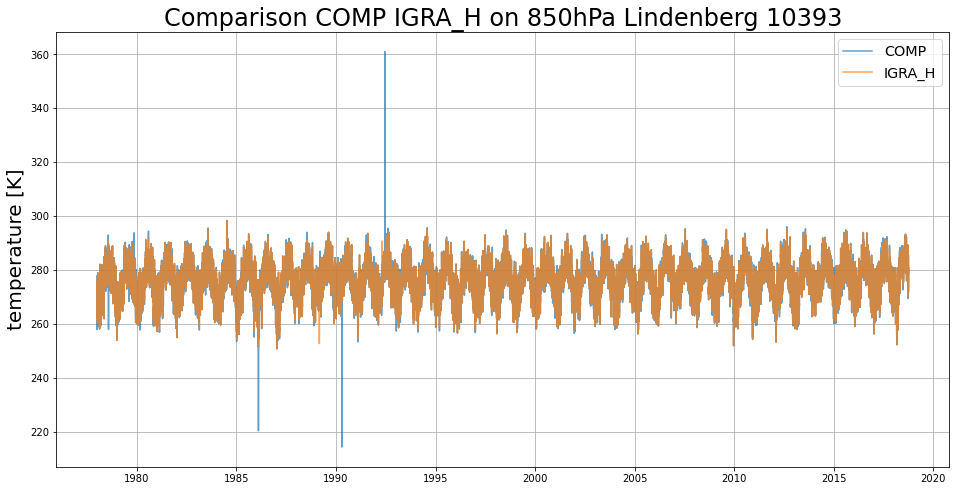

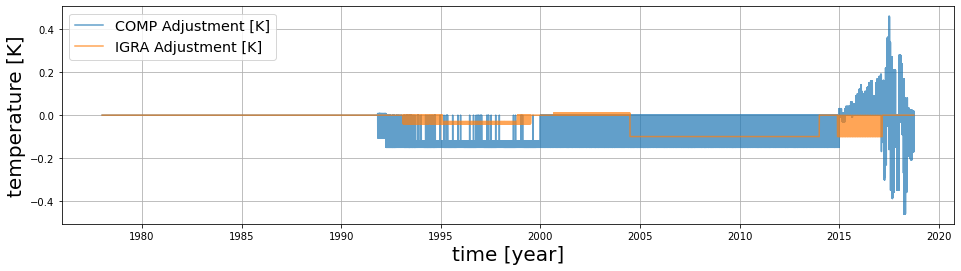

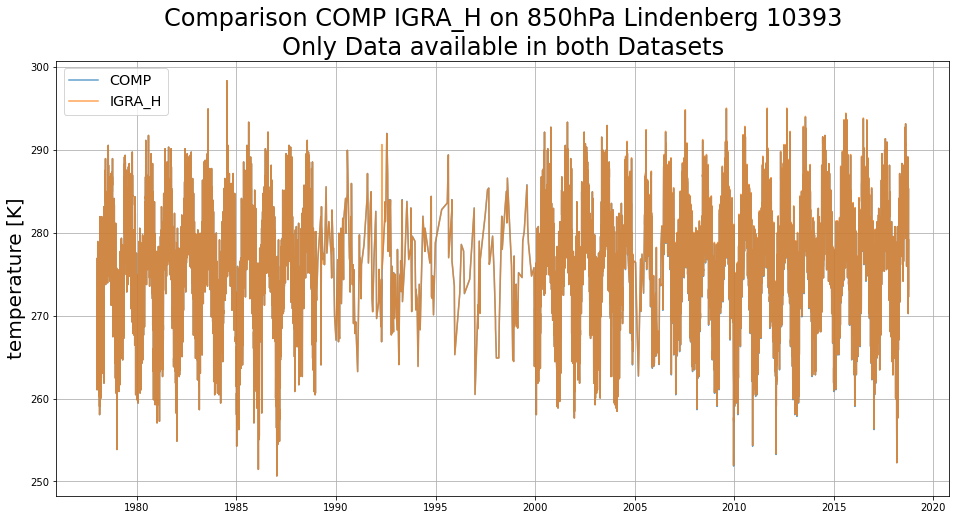

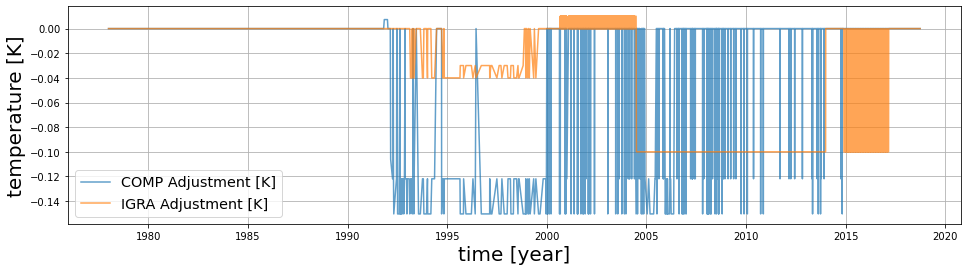

In [10]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    a = igra_original[i]
    b = igrah_original[i]
    c = comp_original[i]
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax1.plot(c.time, np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(b.report_timestamp, np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    ax1.set(ylabel='temperature [K]', title='Comparison COMP IGRA_H on '+str(preslist[i])+'hPa '+loc)
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    ax1.plot(c.time, np.asarray(c.bias_estimate), label = 'COMP Adjustment [K]', alpha=0.7)
    ax1.plot(b.report_timestamp, (np.asarray(a.air_temperature)-np.asarray(b.air_temperature)), label = 'IGRA Adjustment [K]', alpha=0.7)
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]')
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)
    
    a = igra_adjusted[i]
    b = igra_h_adjusted[i]
    c = comp_adjusted[i]
    xax = np.asarray(c.time)
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax1.plot(xax, np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(xax, np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    ax1.set(ylabel='temperature [K]', title='Comparison COMP IGRA_H on '+str(preslist[i])+'hPa '+loc+'\n'+'Only Data available in both Datasets')
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    ax1.plot(xax, np.asarray(c.bias_estimate), label = 'COMP Adjustment [K]', alpha=0.7)
    ax1.plot(xax, (np.asarray(a.air_temperature)-np.asarray(b.air_temperature)), label = 'IGRA Adjustment [K]', alpha=0.7)
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]')
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)
 

## Trends:

Before we adjust the data sets any further, we have a look at the trends. <br>


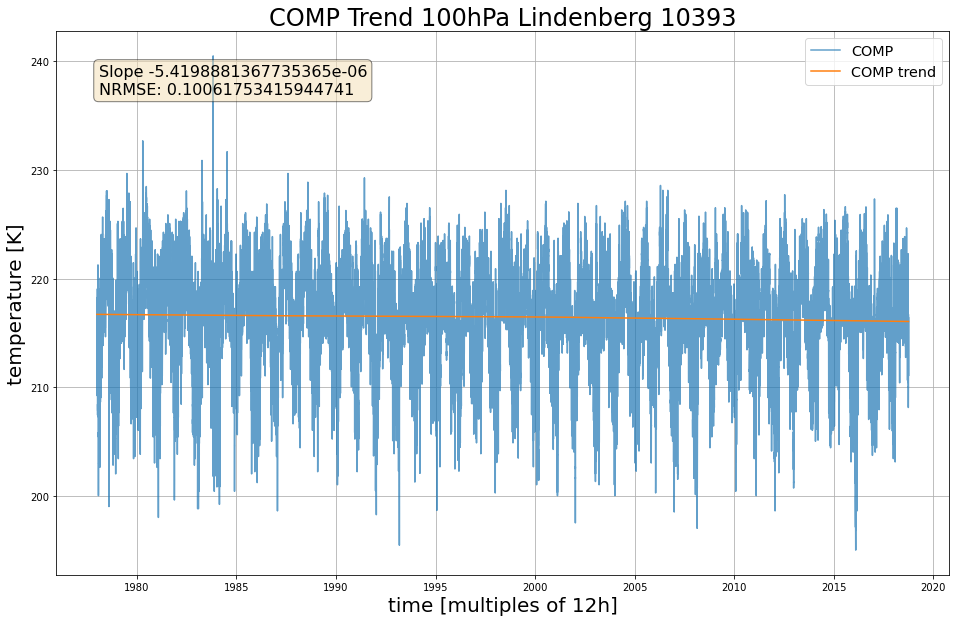

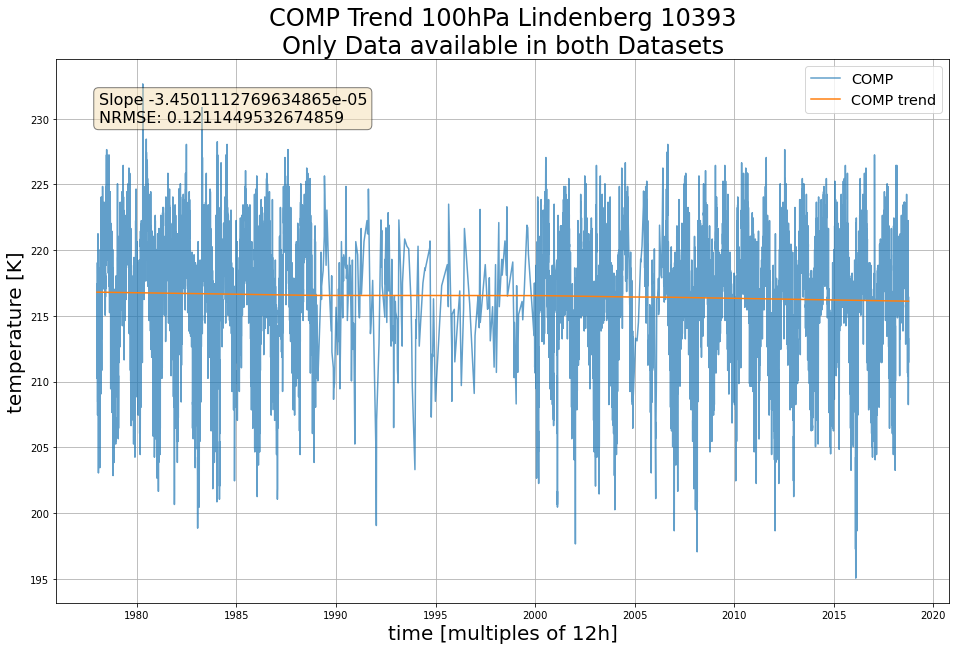

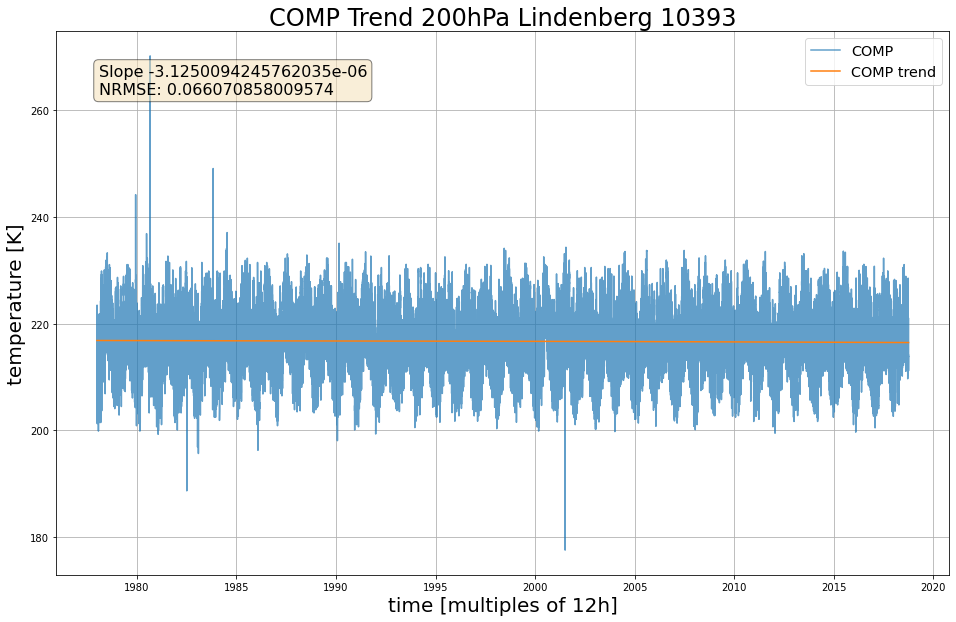

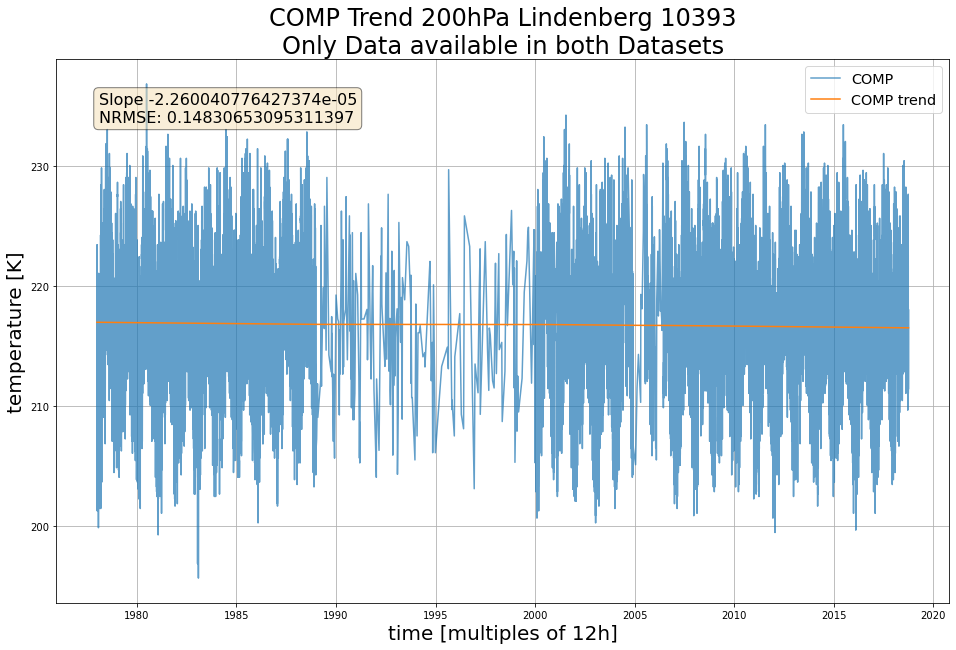

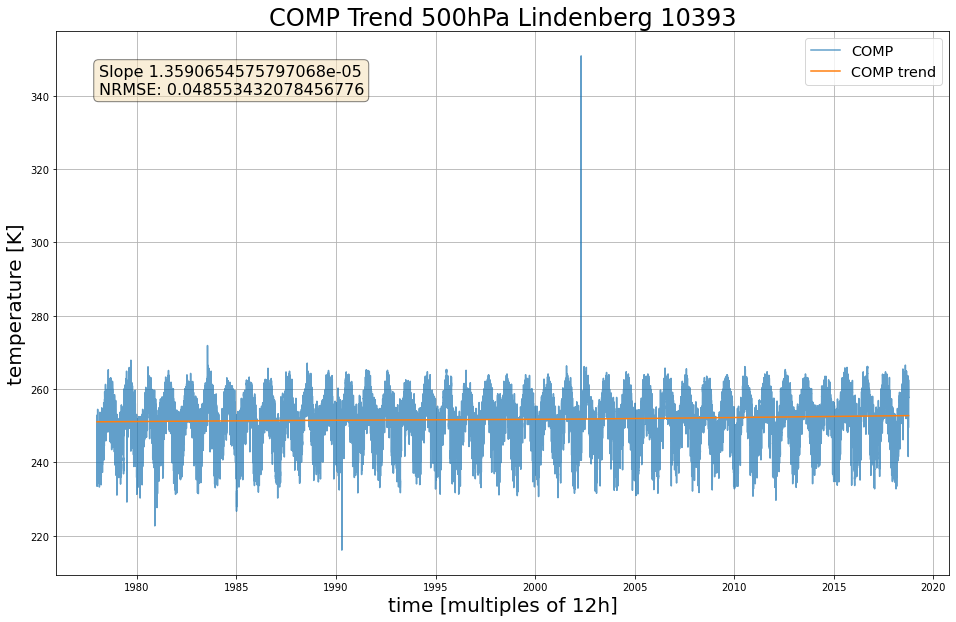

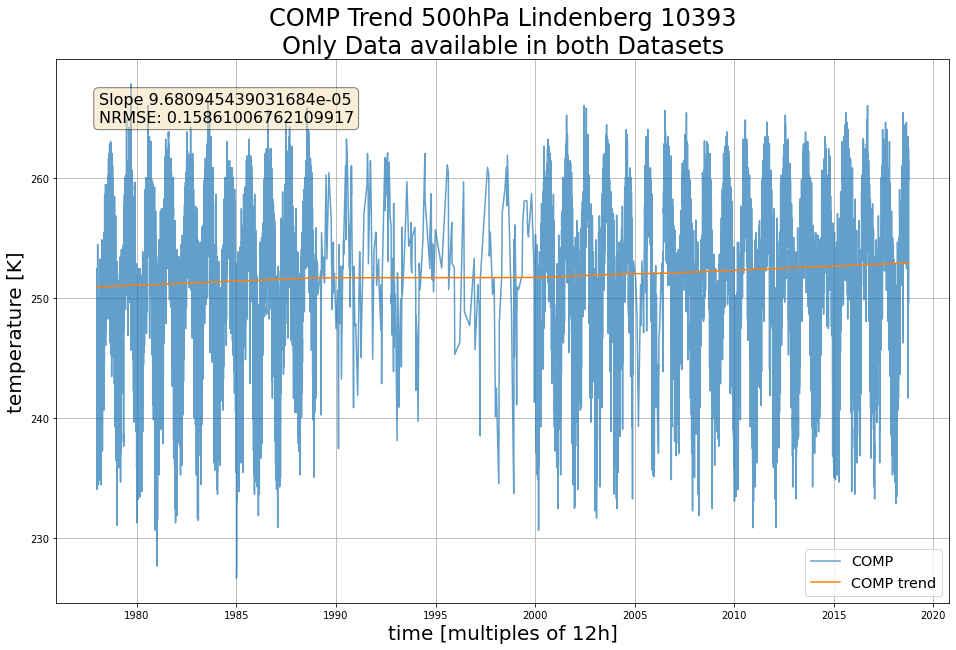

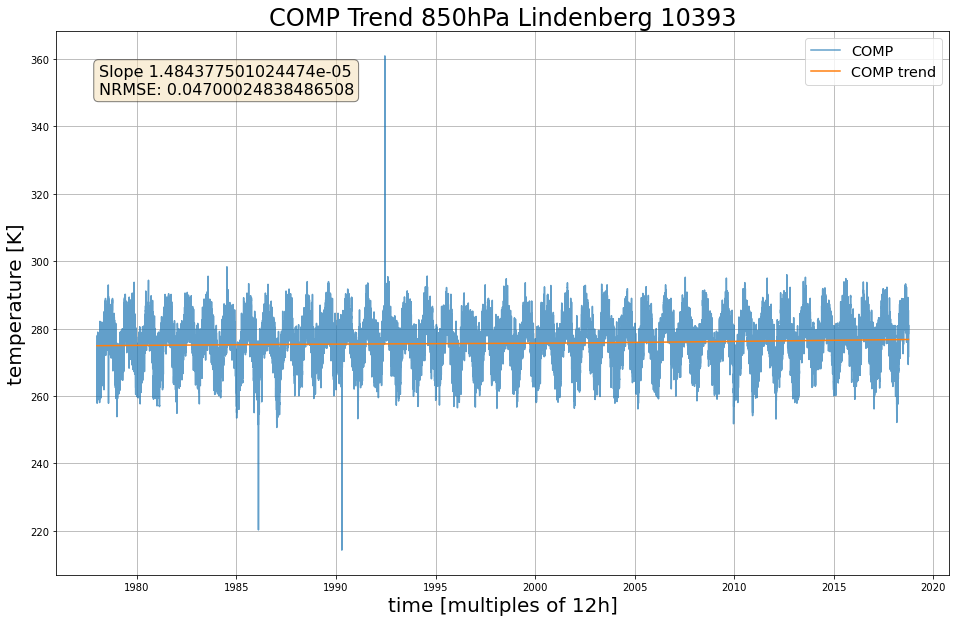

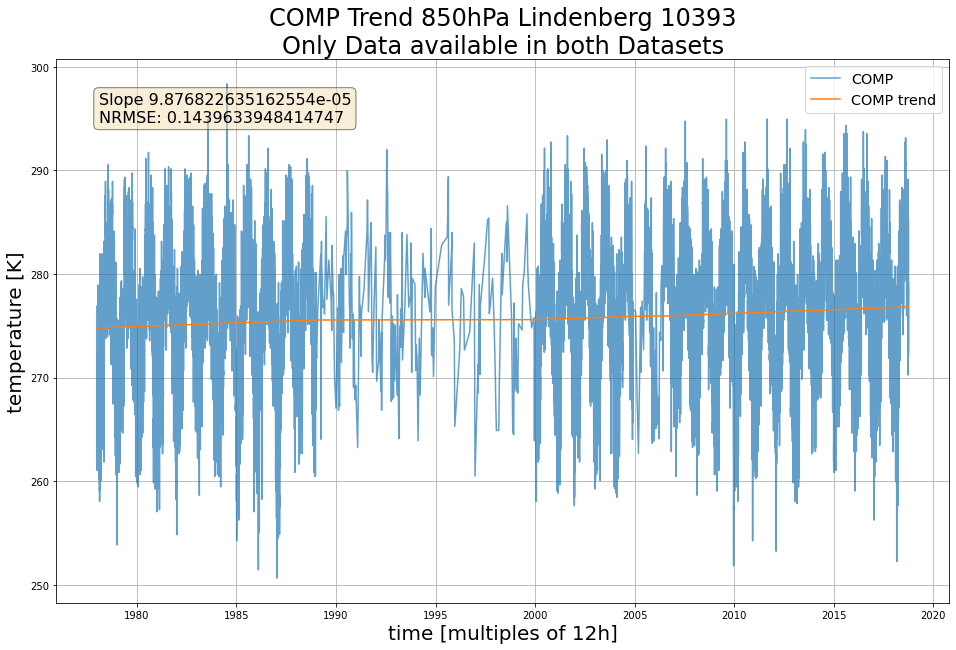

In [11]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    c = comp_original[i]
    xax = np.asarray(c.time)
    selected = c.ta
    datlen = len(selected)
    coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
    mse = residuals[0]/(datlen)
    nrmse = np.sqrt(mse)/(selected.max() - selected.min())

    fig, (ax1) = plt.subplots(1, 1)
    ax1.plot(xax, np.asarray(selected), label = 'COMP', alpha=0.7)
    ax1.plot(xax, [coefficients[0]*x + coefficients[1] for x in range(len(selected))], label = 'COMP trend')
    ax1.set(xlabel ='time [multiples of 12h]', ylabel='temperature [K]', title='COMP Trend '+str(preslist[i])+'hPa '+loc)
    textstr = 'Slope ' + str(coefficients[0]) +'\n'+'NRMSE: ' + str(nrmse)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
    c = comp_adjusted[i]
    xax = np.asarray(c.time)
    
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)

    
    c = comp_adjusted[i]
    xax = np.asarray(c.time)
    selected = c.ta
    datlen = len(selected)
    coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
    mse = residuals[0]/(datlen)
    nrmse = np.sqrt(mse)/(selected.max() - selected.min())

    fig, (ax1) = plt.subplots(1, 1)
    ax1.plot(xax, np.asarray(selected), label = 'COMP', alpha=0.7)
    ax1.plot(xax, [coefficients[0]*x + coefficients[1] for x in range(len(selected))], label = 'COMP trend')
    ax1.set(xlabel ='time [multiples of 12h]', ylabel='temperature [K]', title='COMP Trend '+str(preslist[i])+'hPa '+loc+'\n'+'Only Data available in both Datasets')
    textstr = 'Slope ' + str(coefficients[0]) +'\n'+'NRMSE: ' + str(nrmse)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)


    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)
    

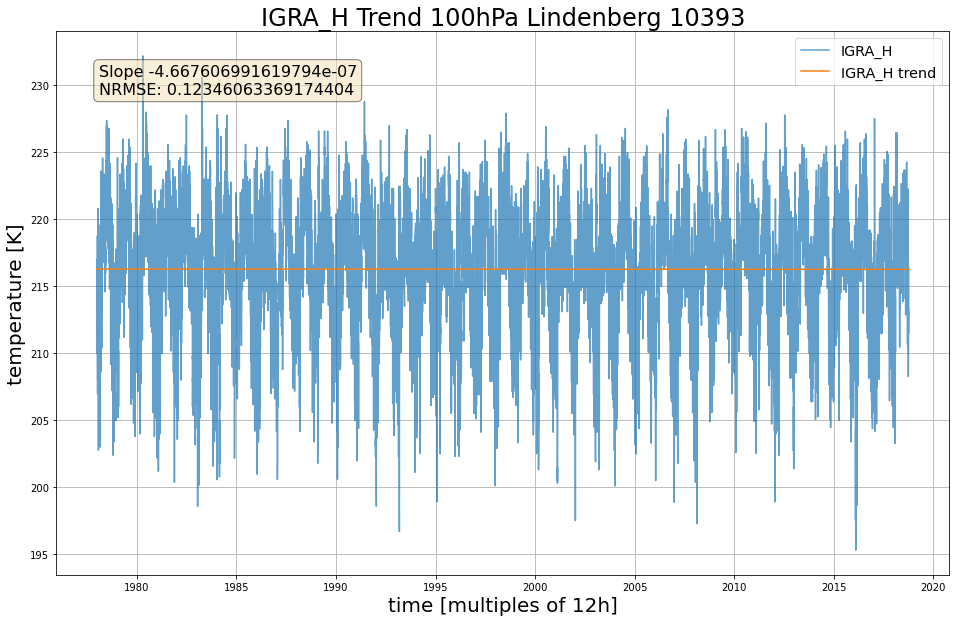

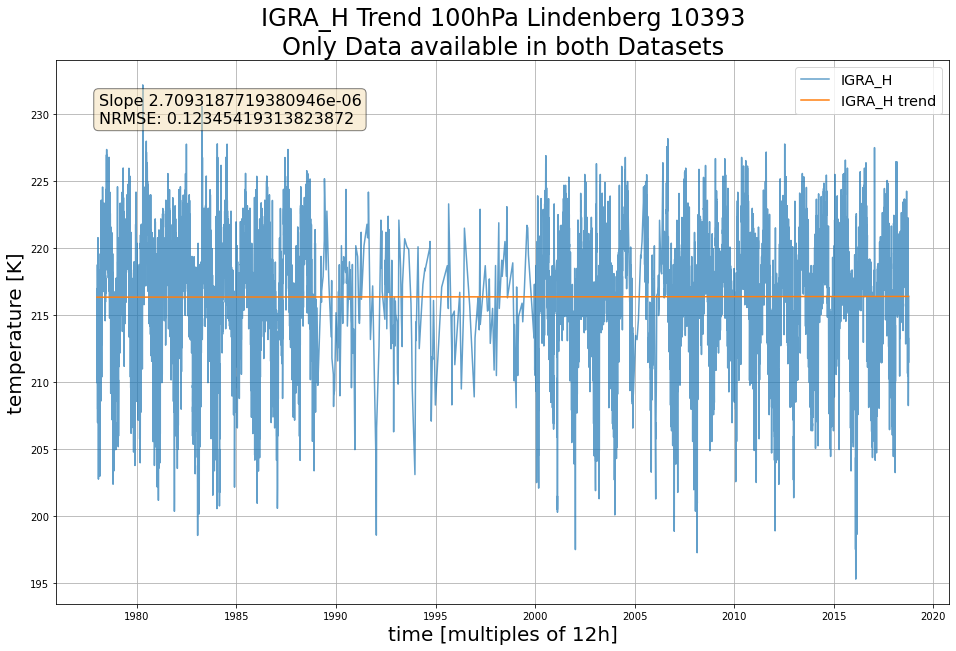

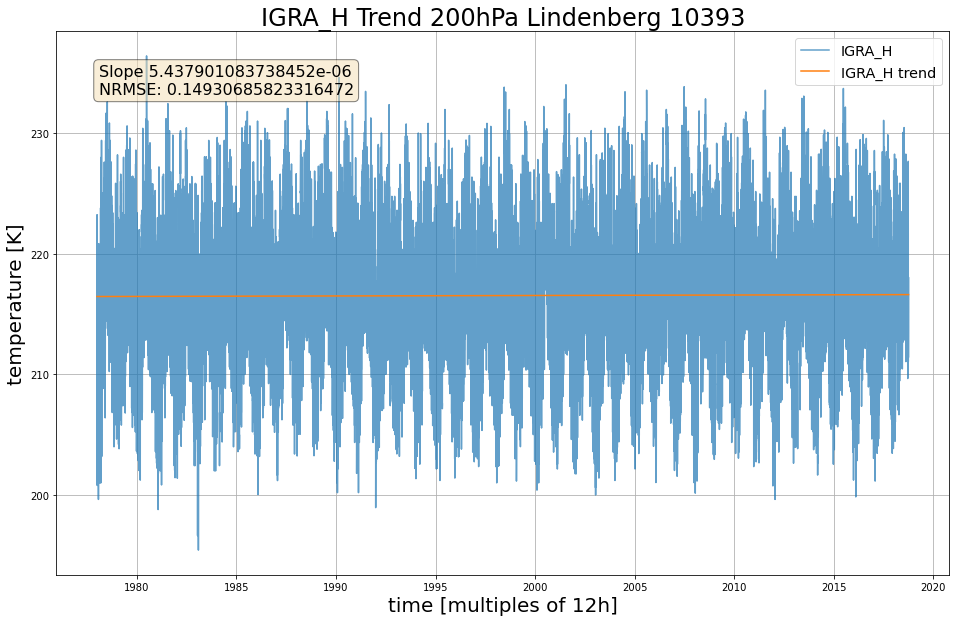

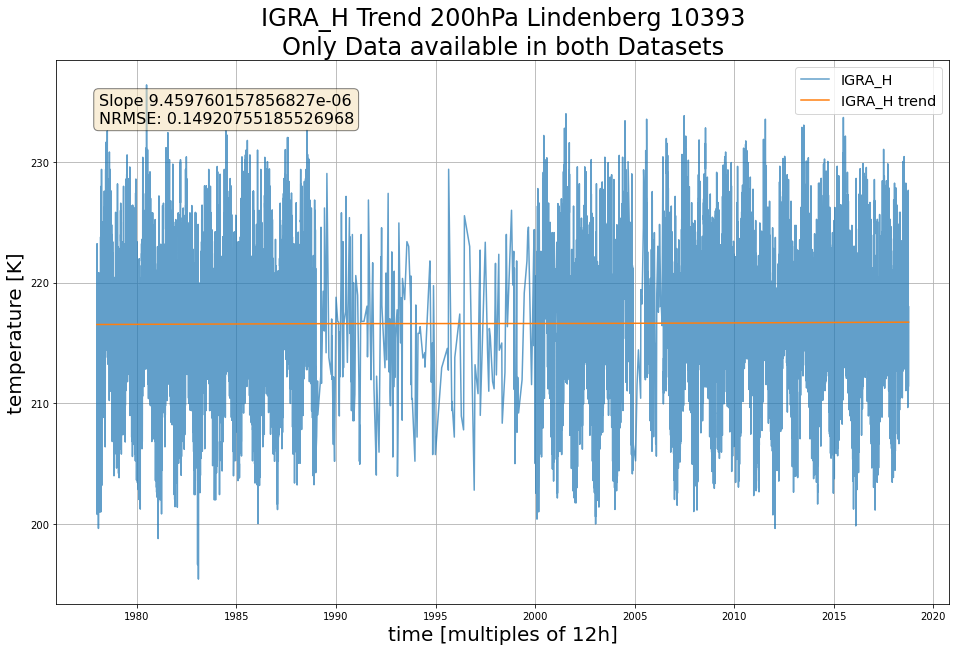

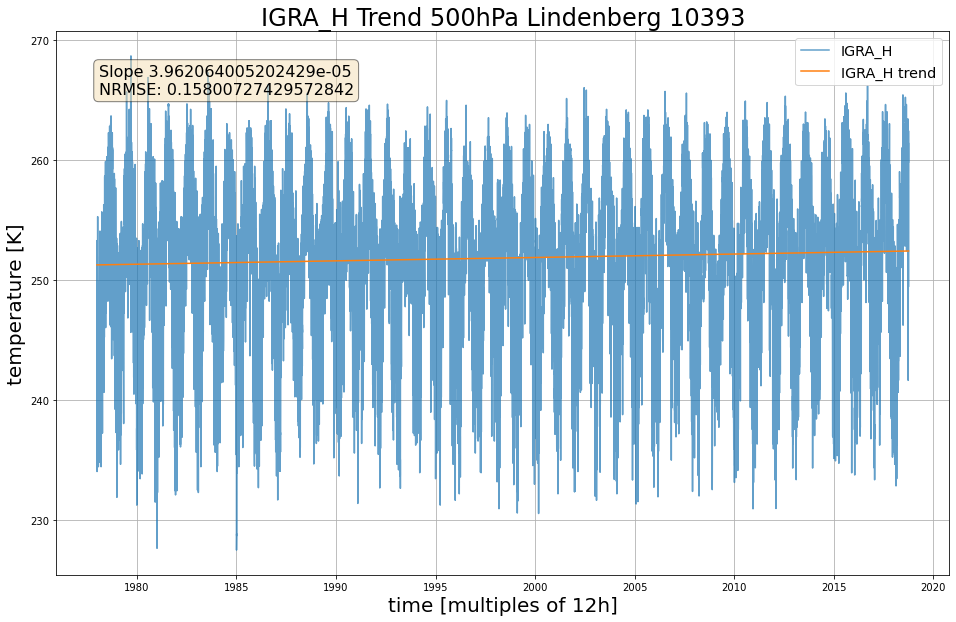

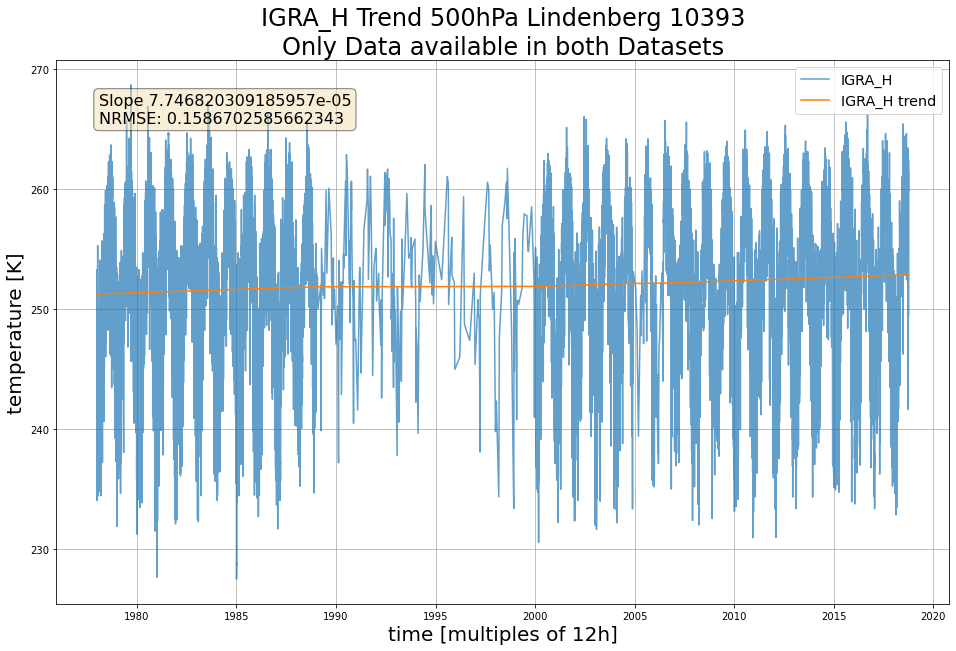

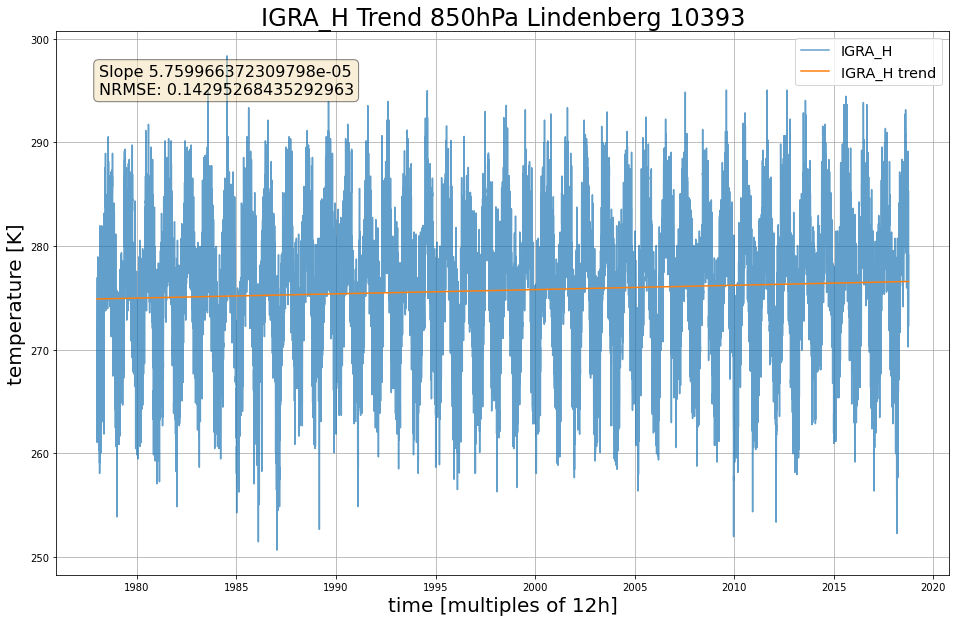

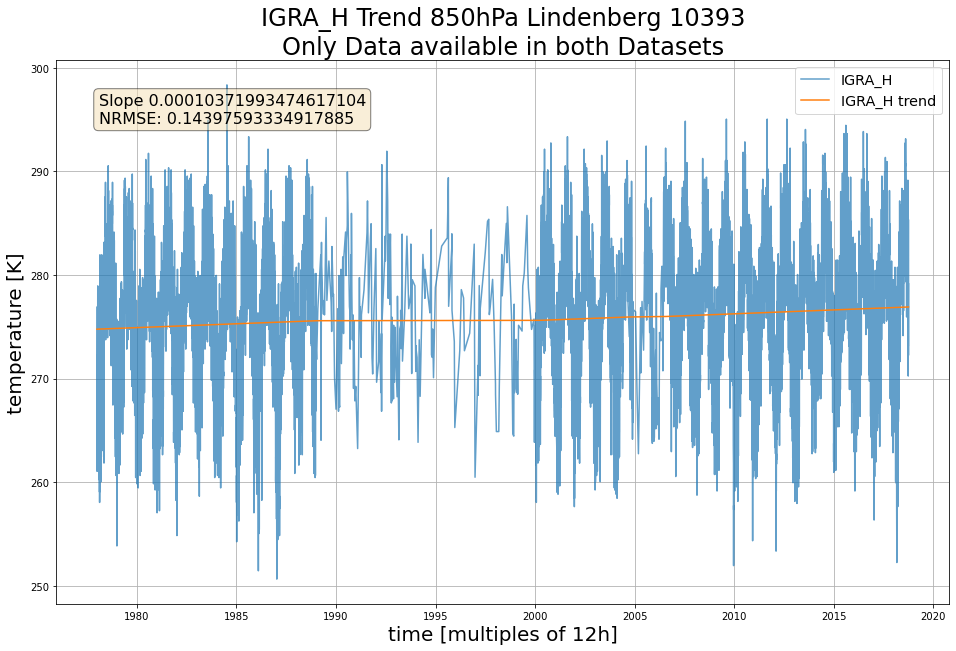

In [12]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    c = igrah_original[i]
    xax = np.asarray(c.report_timestamp)
    selected = c.air_temperature
    datlen = len(selected)
    coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
    mse = residuals[0]/(datlen)
    nrmse = np.sqrt(mse)/(selected.max() - selected.min())

    fig, (ax1) = plt.subplots(1, 1)
    ax1.plot(xax, np.asarray(selected), label = 'IGRA_H', alpha=0.7)
    ax1.plot(xax, [coefficients[0]*x + coefficients[1] for x in range(len(selected))], label = 'IGRA_H trend')
    ax1.set(xlabel ='time [multiples of 12h]', ylabel='temperature [K]', title='IGRA_H Trend '+str(preslist[i])+'hPa '+loc)
    textstr = 'Slope ' + str(coefficients[0]) +'\n'+'NRMSE: ' + str(nrmse)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
    c = comp_adjusted[i]
    xax = np.asarray(c.time)
    
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)

    
    c = igra_h_adjusted[i]
    xax = np.asarray(c.report_timestamp)
    selected = c.air_temperature
    datlen = len(selected)
    coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
    mse = residuals[0]/(datlen)
    nrmse = np.sqrt(mse)/(selected.max() - selected.min())

    fig, (ax1) = plt.subplots(1, 1)
    ax1.plot(xax, np.asarray(selected), label = 'IGRA_H', alpha=0.7)
    ax1.plot(xax, [coefficients[0]*x + coefficients[1] for x in range(len(selected))], label = 'IGRA_H trend')
    ax1.set(xlabel ='time [multiples of 12h]', ylabel='temperature [K]', title='IGRA_H Trend '+str(preslist[i])+'hPa '+loc+'\n'+'Only Data available in both Datasets')
    textstr = 'Slope ' + str(coefficients[0]) +'\n'+'NRMSE: ' + str(nrmse)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)


    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)
    

## Moving Average

We remove the monthly variation, by creating a moving average over 14 days and subtracting it from the original data. <br>
Every data set is treated the same way, so they stay comparable.

In [13]:
# reduced data
#
comp_ma = []
igra_h_ma = []
igra_ma = []

for i in range(len(comp_adjusted)):
    N = 14
    S = 7
    E = 6
    
    datain = np.asarray(comp_adjusted[i].ta)
    rm = np.convolve(datain, np.ones((N,))/N, mode='valid')
    start = np.array([rm[0]]*S)
    end = np.array([rm[-1]]*E)
    rm = np.concatenate((start, rm))
    rm = np.concatenate((rm, end))
    comp_ma.append(comp_adjusted[i])
    comp_ma[i].ta = comp_ma[i].ta - rm
    
    datain = np.asarray(igra_adjusted[i].air_temperature)
    rm = np.convolve(datain, np.ones((N,))/N, mode='valid')
    start = np.array([rm[0]]*S)
    end = np.array([rm[-1]]*E)
    rm = np.concatenate((start, rm))
    rm = np.concatenate((rm, end))
    igra_ma.append(igra_adjusted[i])
    igra_ma[i].air_temperature = igra_ma[i].air_temperature - rm
    
    datain = np.asarray(igra_h_adjusted[i].air_temperature)
    rm = np.convolve(datain, np.ones((N,))/N, mode='valid')
    start = np.array([rm[0]]*S)
    end = np.array([rm[-1]]*E)
    rm = np.concatenate((start, rm))
    rm = np.concatenate((rm, end))
    igra_h_ma.append(igra_h_adjusted[i])
    igra_h_ma[i].air_temperature = igra_h_ma[i].air_temperature - rm

In [14]:
# original data
#
comp_o_ma = []
igrah_o_ma = []
igra_o_ma = []

for i in range(len(comp_original)):
    N = 14
    S = 7
    E = 6
    
    datain = np.asarray(comp_original[i].ta)
    rm = np.convolve(datain, np.ones((N,))/N, mode='valid')
    start = np.array([rm[0]]*S)
    end = np.array([rm[-1]]*E)
    rm = np.concatenate((start, rm))
    rm = np.concatenate((rm, end))
    comp_o_ma.append(comp_original[i])
    comp_o_ma[i].ta = comp_o_ma[i].ta - rm

    
for i in range(len(igra_original)):
    N = 14
    S = 7
    E = 6
    
    datain = np.asarray(igra_original[i].air_temperature)
    rm = np.convolve(datain, np.ones((N,))/N, mode='valid')
    start = np.array([rm[0]]*S)
    end = np.array([rm[-1]]*E)
    rm = np.concatenate((start, rm))
    rm = np.concatenate((rm, end))
    igra_o_ma.append(igra_original[i])
    igra_o_ma[i].air_temperature = igra_o_ma[i].air_temperature - rm
    
    datain = np.asarray(igrah_original[i].air_temperature)
    rm = np.convolve(datain, np.ones((N,))/N, mode='valid')
    start = np.array([rm[0]]*S)
    end = np.array([rm[-1]]*E)
    rm = np.concatenate((start, rm))
    rm = np.concatenate((rm, end))
    igrah_o_ma.append(igrah_original[i])
    igrah_o_ma[i].air_temperature = igrah_o_ma[i].air_temperature - rm

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Day and Night Data:

We split the data sets into a day ascent and night ascent part. <br>

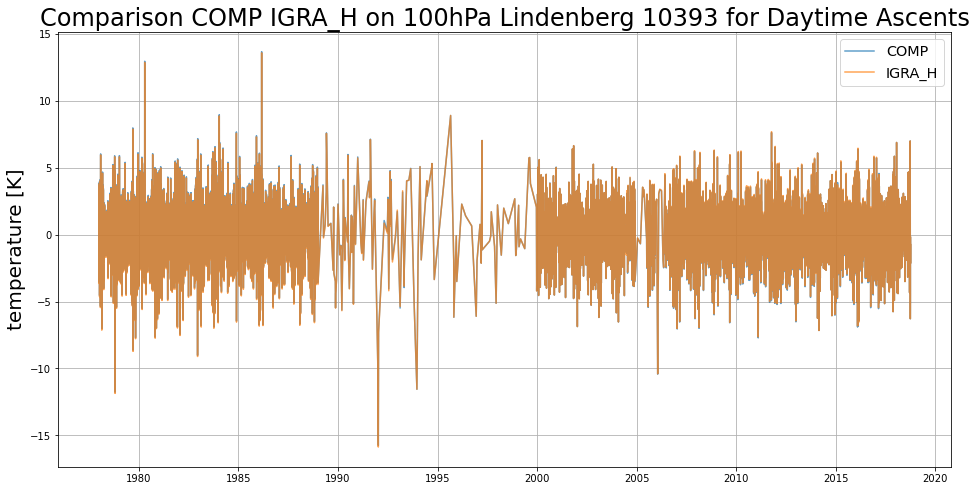

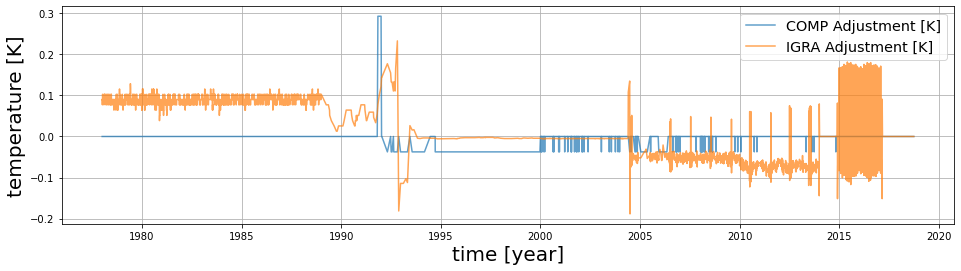

COMP Adjustment MEAN: -0.0004176456043143913
COMP Adjustment MIN: -0.037485000000000004
COMP Adjustment MAX: 0.29285005
IGRA Adjustment MEAN: 0.007584853975545676
IGRA Adjustment MIN: -0.1885714285714073
IGRA Adjustment MAX: 0.23285714285711379


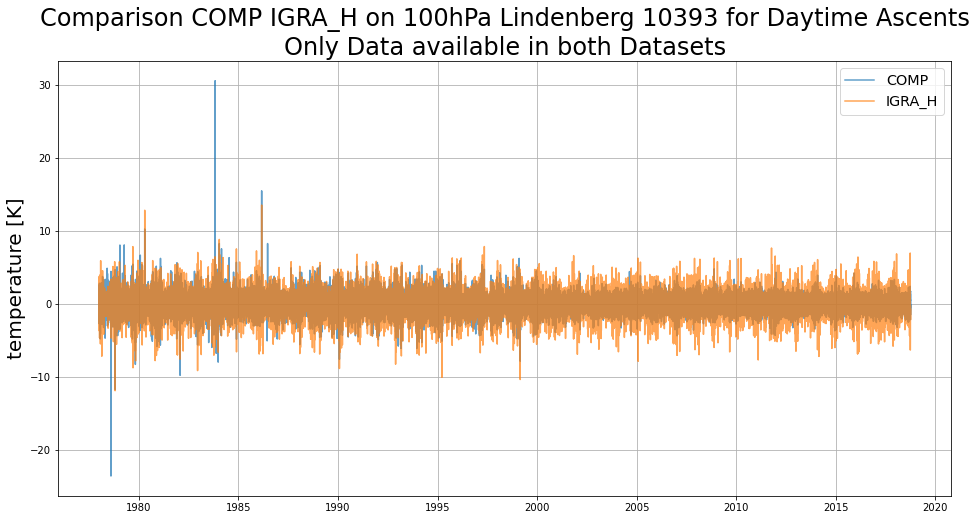

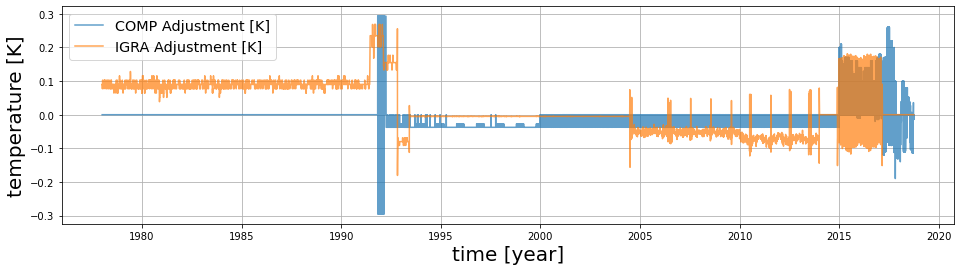

COMP Adjustment MEAN: -0.006198555325494096
COMP Adjustment MIN: -0.29512858
COMP Adjustment MAX: 0.2928501
IGRA Adjustment MEAN: 0.013335077743671707
IGRA Adjustment MIN: -0.18071428571431625
IGRA Adjustment MAX: 0.2685714285714482


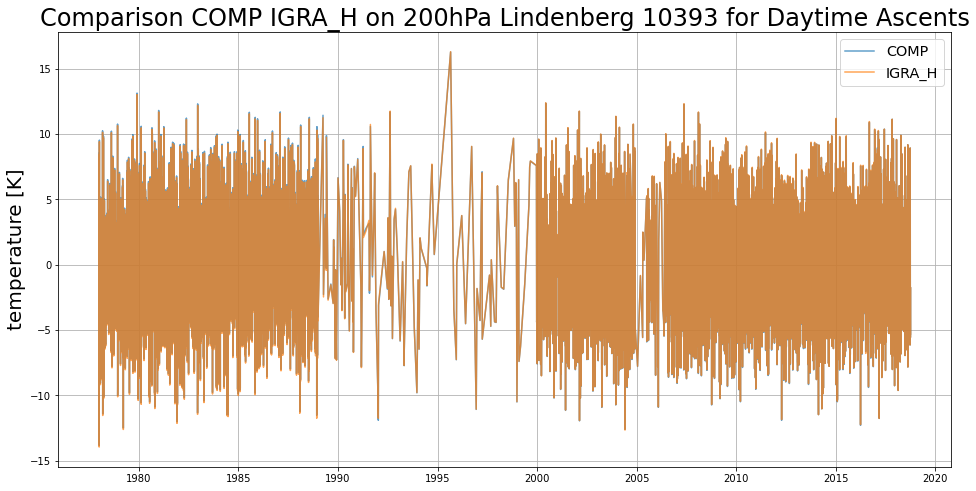

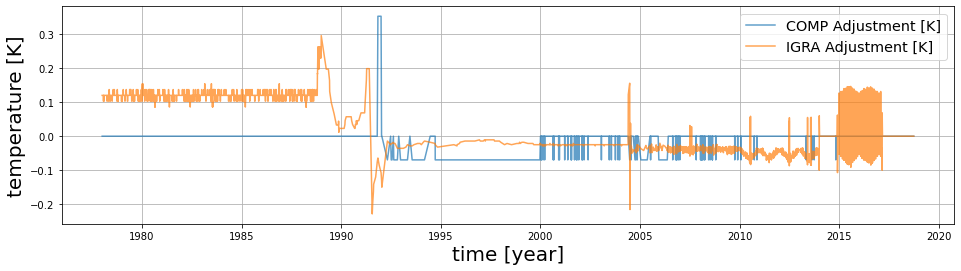

COMP Adjustment MEAN: -0.0008499180108472587
COMP Adjustment MIN: -0.06968049999999999
COMP Adjustment MAX: 0.35268515
IGRA Adjustment MEAN: 0.02460924739288901
IGRA Adjustment MIN: -0.22857142857139934
IGRA Adjustment MAX: 0.2957142857142969


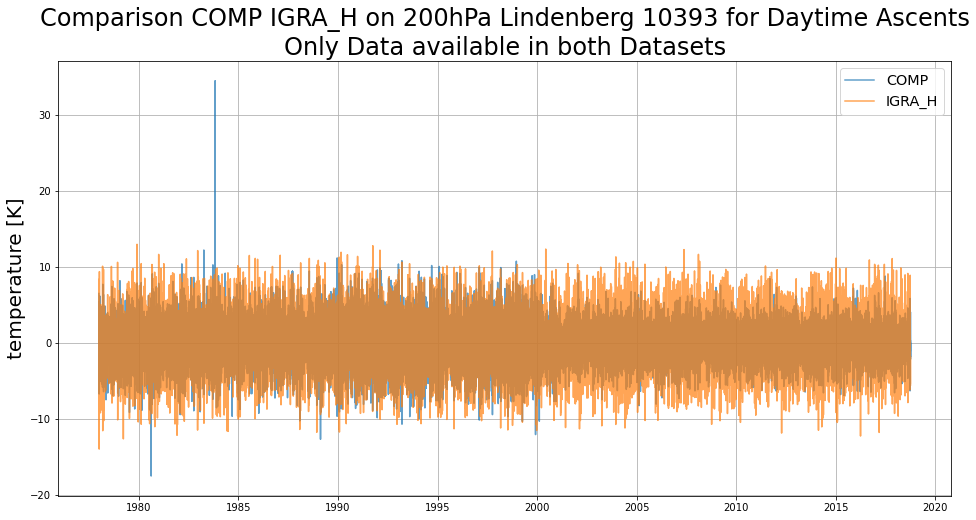

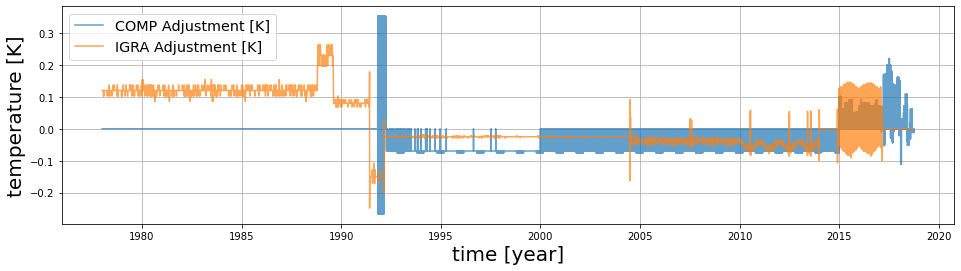

COMP Adjustment MEAN: -0.015284167654629076
COMP Adjustment MIN: -0.2668369
COMP Adjustment MAX: 0.35268520000000003
IGRA Adjustment MEAN: 0.015318803536889006
IGRA Adjustment MIN: -0.248571428571438
IGRA Adjustment MAX: 0.26285714285717177


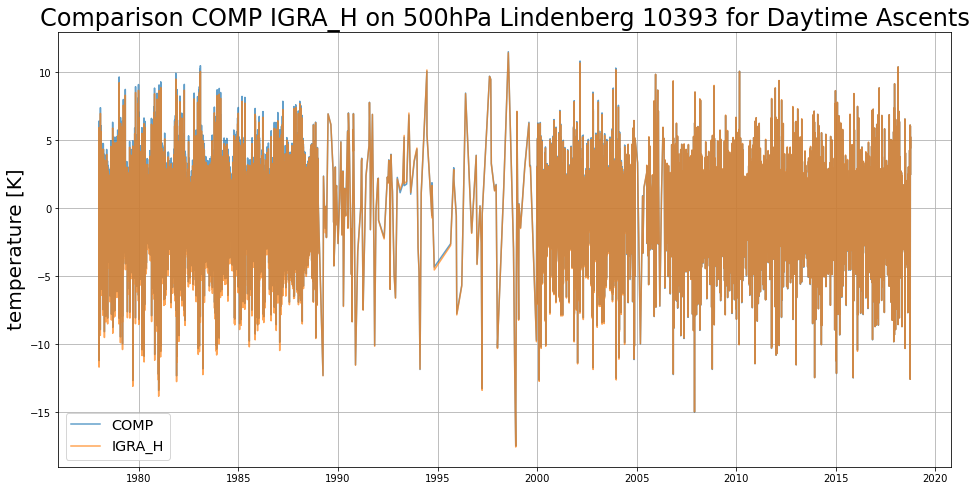

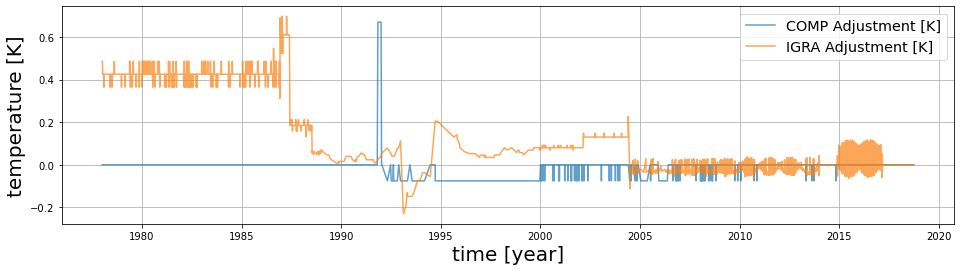

COMP Adjustment MEAN: -0.0008454638600329105
COMP Adjustment MIN: -0.07565009
COMP Adjustment MAX: 0.66927344
IGRA Adjustment MEAN: 0.1560951090338363
IGRA Adjustment MIN: -0.23071428571427077
IGRA Adjustment MAX: 0.6971428571428646


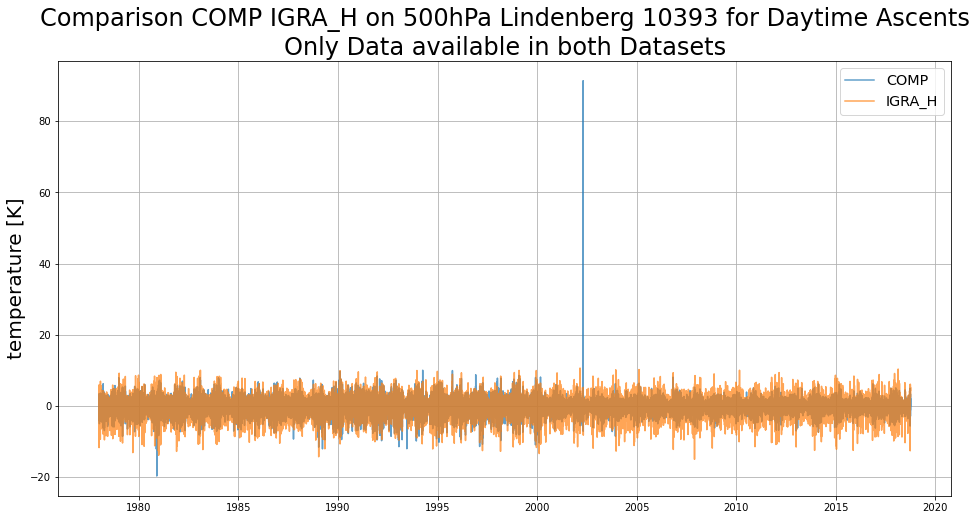

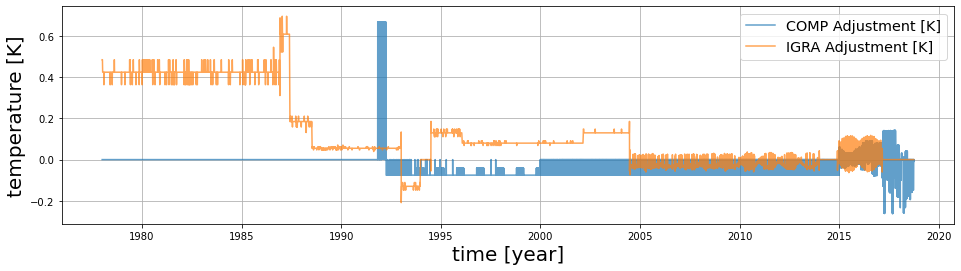

COMP Adjustment MEAN: -0.01606686960564164
COMP Adjustment MIN: -0.26426297
COMP Adjustment MAX: 0.6692736
IGRA Adjustment MEAN: 0.12485001810548117
IGRA Adjustment MIN: -0.20928571428572695
IGRA Adjustment MAX: 0.6971428571428646


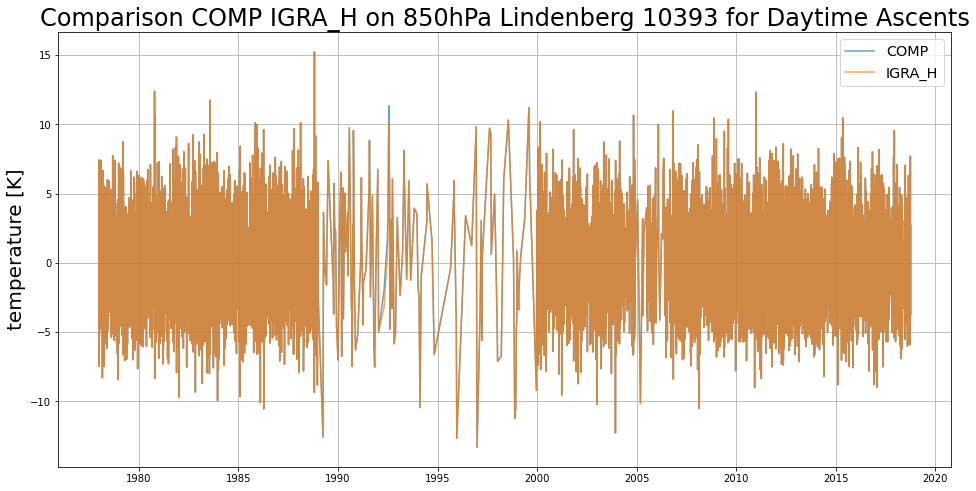

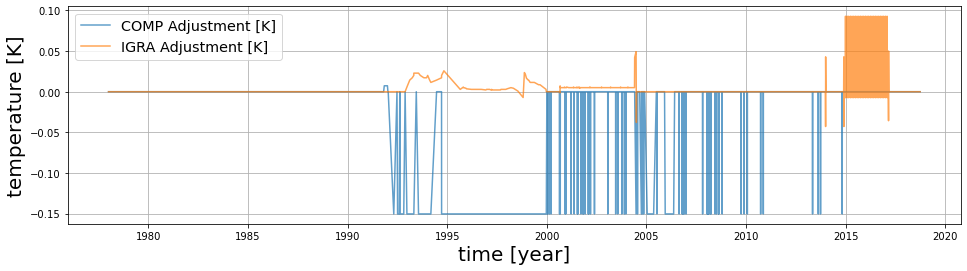

COMP Adjustment MEAN: -0.002063691848611783
COMP Adjustment MIN: -0.15038255
COMP Adjustment MAX: 0.0073034666
IGRA Adjustment MEAN: 0.0008257438604733123
IGRA Adjustment MIN: -0.042857142857201325
IGRA Adjustment MAX: 0.0928571428572127


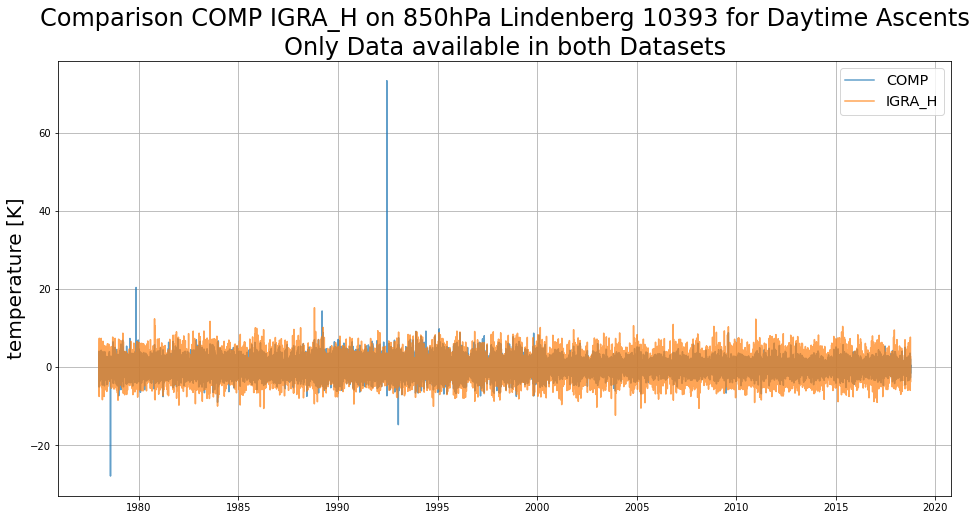

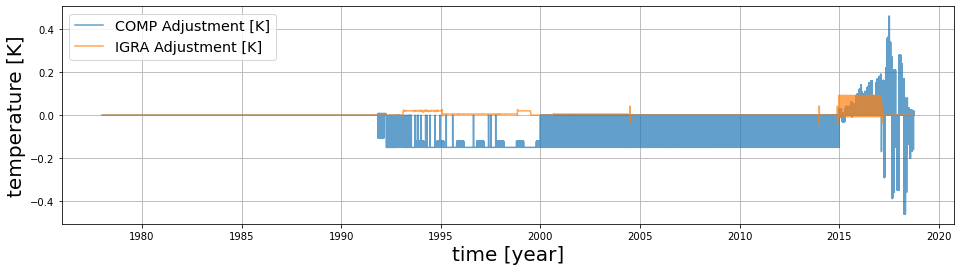

COMP Adjustment MEAN: -0.03600353709670882
COMP Adjustment MIN: -0.4609116
COMP Adjustment MAX: 0.46138805
IGRA Adjustment MEAN: 0.00225642906033041
IGRA Adjustment MIN: -0.042857142857201325
IGRA Adjustment MAX: 0.0928571428572127


In [15]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    a = igra_ma[i]
    a = a[a.report_timestamp.dt.hour == 12]
    b = igra_h_ma[i]
    b = b[b.report_timestamp.dt.hour == 12]
    c = comp_ma[i]
    c = c[c.time.dt.hour == 12]
    xax = np.asarray(c.time)    
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax1.plot(xax, np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(xax, np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    ax1.set(ylabel='temperature [K]', title='Comparison COMP IGRA_H on '+str(preslist[i])+'hPa '+loc+' for Daytime Ascents')
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    ca = np.asarray(c.bias_estimate)
    ax1.plot(xax, ca, label = 'COMP Adjustment [K]', alpha=0.7)
    ia = np.asarray(a.air_temperature)-np.asarray(b.air_temperature)
    ax1.plot(xax, ia, label = 'IGRA Adjustment [K]', alpha=0.7)
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]')
    ax1.legend( loc='best')
    ax1.grid()
#     textstr = ('COMP Adjustment MEAN: ' + str(ca.mean()) + '\n' +'COMP Adjustment MIN: ' + str(ca.min()) + '\n' +'COMP Adjustment MAX: ' + str(ca.max()) + '\n' +'IGRA Adjustment MEAN: ' + str(ia.mean())+ '\n' +'IGRA Adjustment MIN: ' + str(ia.min())  + '\n' +'IGRA Adjustment MAX: ' + str(ia.max()))
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#     ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
    plt.show()
    plt.close(fig)
    
    print('COMP Adjustment MEAN: ' + str(ca.mean()))
    print('COMP Adjustment MIN: ' + str(ca.min()))
    print('COMP Adjustment MAX: ' + str(ca.max()))
    print('IGRA Adjustment MEAN: ' + str(ia.mean()))
    print('IGRA Adjustment MIN: ' + str(ia.min()))
    print('IGRA Adjustment MAX: ' + str(ia.max()))
    
    
    a = igra_o_ma[i]
    a = a[a.report_timestamp.dt.hour >= 6]
    a = a[a.report_timestamp.dt.hour < 18]
    b = igrah_o_ma[i]
    b = b[b.report_timestamp.dt.hour >= 6]
    b = b[b.report_timestamp.dt.hour < 18]
    c = comp_o_ma[i]
    c = c[c.time.dt.hour >= 6]
    c = c[c.time.dt.hour < 18]
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax1.plot(np.asarray(c.time), np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(np.asarray(b.report_timestamp), np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    ax1.set(ylabel='temperature [K]', title='Comparison COMP IGRA_H on '+str(preslist[i])+'hPa '+loc+' for Daytime Ascents'+'\n'+'Only Data available in both Datasets')
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    ca = np.asarray(c.bias_estimate)
    ax1.plot(np.asarray(c.time), ca, label = 'COMP Adjustment [K]', alpha=0.7)
    ia = np.asarray(a.air_temperature)-np.asarray(b.air_temperature)
    ax1.plot(np.asarray(a.report_timestamp), ia, label = 'IGRA Adjustment [K]', alpha=0.7)
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]')
    ax1.legend( loc='best')
    ax1.grid()
#     textstr = ('COMP Adjustment MEAN: ' + str(ca.mean()) + '\n' +'COMP Adjustment MIN: ' + str(ca.min()) + '\n' +'COMP Adjustment MAX: ' + str(ca.max()) + '\n' +'IGRA Adjustment MEAN: ' + str(ia.mean())+ '\n' +'IGRA Adjustment MIN: ' + str(ia.min())  + '\n' +'IGRA Adjustment MAX: ' + str(ia.max()))
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#     ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
    plt.show()
    plt.close(fig)
    
    print('COMP Adjustment MEAN: ' + str(ca.mean()))
    print('COMP Adjustment MIN: ' + str(ca.min()))
    print('COMP Adjustment MAX: ' + str(ca.max()))
    print('IGRA Adjustment MEAN: ' + str(ia.mean()))
    print('IGRA Adjustment MIN: ' + str(ia.min()))
    print('IGRA Adjustment MAX: ' + str(ia.max()))

In [16]:
a = igra_o_ma[0]
a[a.report_timestamp.dt.hour < 6].append(a[a.report_timestamp.dt.hour > 18])

station_name          report_timestamp  longitude  latitude  \
10     GMM00010393 1978-01-01 00:00:00+00:00    14.1167   52.2167   
80     GMM00010393 1978-01-02 00:00:00+00:00    14.1167   52.2167   
117    GMM00010393 1978-01-03 00:00:00+00:00    14.1167   52.2167   
210    GMM00010393 1978-01-05 00:00:00+00:00    14.1167   52.2167   
260    GMM00010393 1978-01-06 00:00:00+00:00    14.1167   52.2167   
...            ...                       ...        ...       ...   
12418  GMM00010393 2006-05-28 23:00:00+00:00    14.1167   52.2167   
12488  GMM00010393 2006-05-29 23:00:00+00:00    14.1167   52.2167   
12560  GMM00010393 2006-05-30 23:00:00+00:00    14.1167   52.2167   
16818  GMM00010393 2006-07-18 23:00:00+00:00    14.1167   52.2167   
1389   GMM00010393 2008-01-15 23:00:00+00:00    14.1167   52.2167   

       height_of_station_above_sea_level  air_pressure  air_temperature  \
10                                   112         10000        -3.200000   
80                                   112         10000        -3.400000   
117                                  112         10000         0.200000   
210                                  112         10000         1.400000   
260                                  112         10000        -0.457143   
...                                  ...           ...              ...   
12418                                112         10000         0.128571   
12488                                112         10000         2.071429   
12560                                112         10000         1.514286   
16818                                112         10000        -1.285714   
1389                                 112         10000        -2.271429   

       relative_humidity  
10                   NaN  
80                   NaN  
117                  NaN  
210                  NaN  
260                  NaN  
...                  ...  
12418               0.00  
12488               0.00  
12560               0.00  
16818               0.00  
1389                5.58  

[14140 rows x 8 columns]

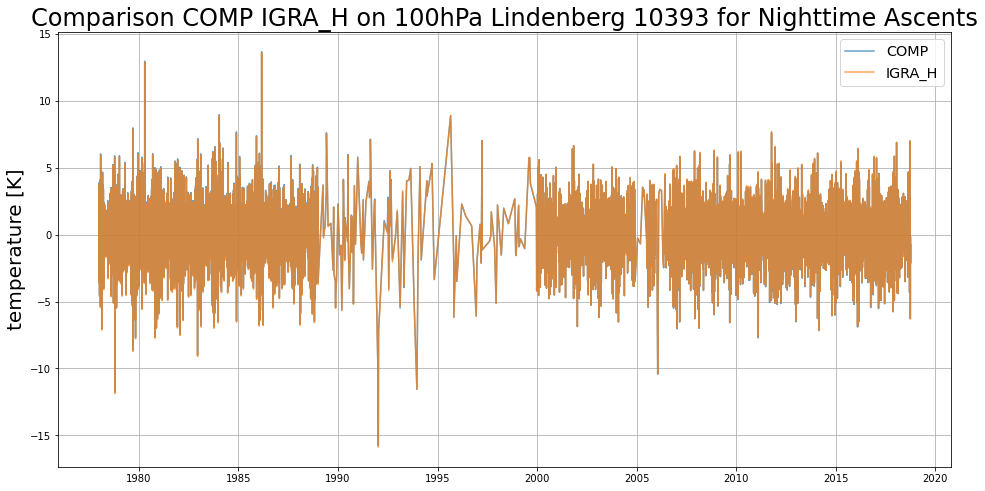

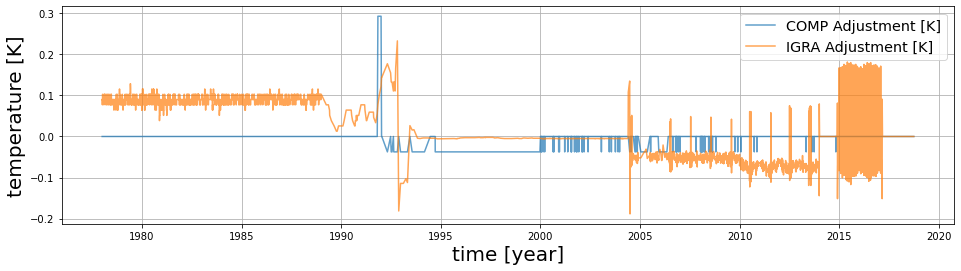

COMP Adjustment MEAN: -0.0004176456043143913
COMP Adjustment MIN: -0.037485000000000004
COMP Adjustment MAX: 0.29285005
IGRA Adjustment MEAN: 0.007584853975545676
IGRA Adjustment MIN: -0.1885714285714073
IGRA Adjustment MAX: 0.23285714285711379


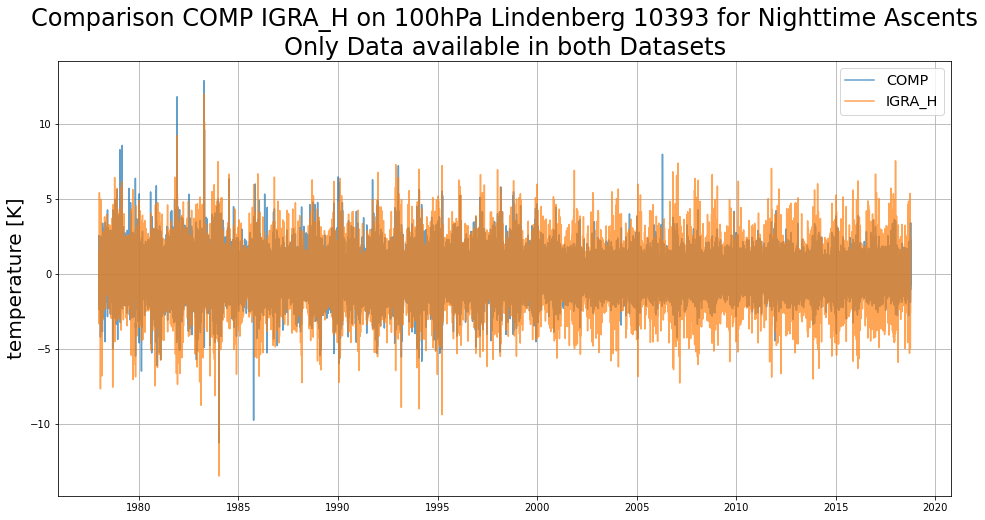

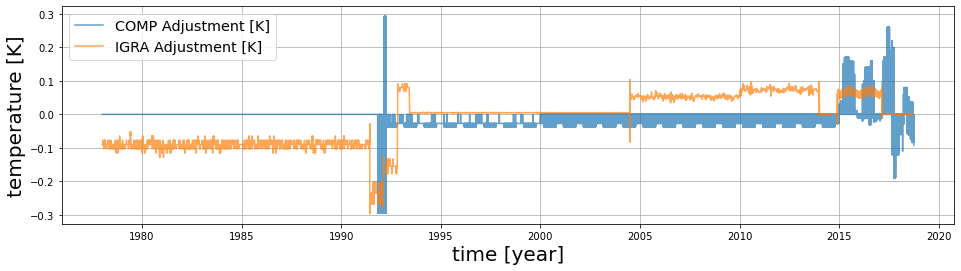

COMP Adjustment MEAN: -0.008261045812428395
COMP Adjustment MIN: -0.29512858
COMP Adjustment MAX: 0.29285005
IGRA Adjustment MEAN: -0.013399929278641332
IGRA Adjustment MIN: -0.29714285714288735
IGRA Adjustment MAX: 0.10428571428570876


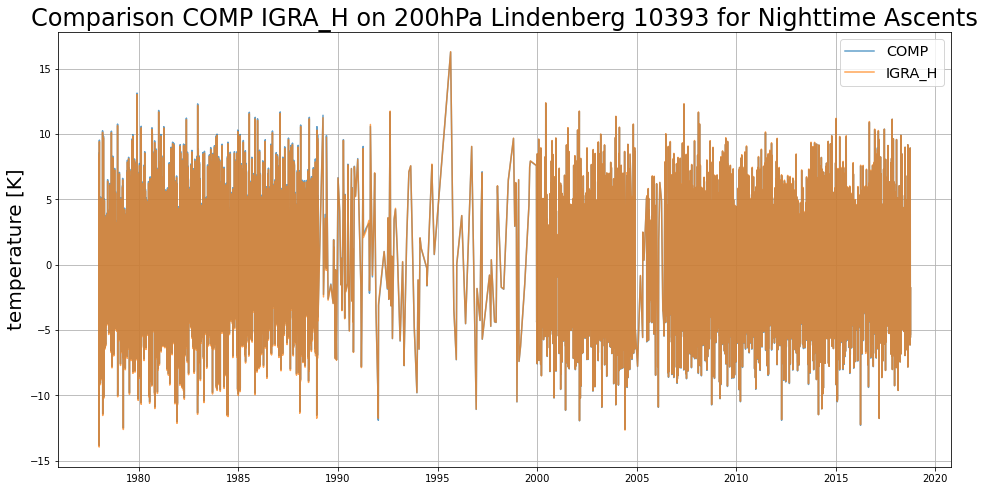

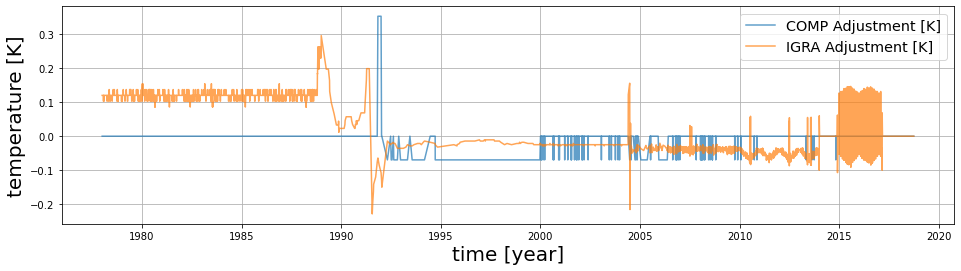

COMP Adjustment MEAN: -0.0008499180108472587
COMP Adjustment MIN: -0.06968049999999999
COMP Adjustment MAX: 0.35268515
IGRA Adjustment MEAN: 0.02460924739288901
IGRA Adjustment MIN: -0.22857142857139934
IGRA Adjustment MAX: 0.2957142857142969


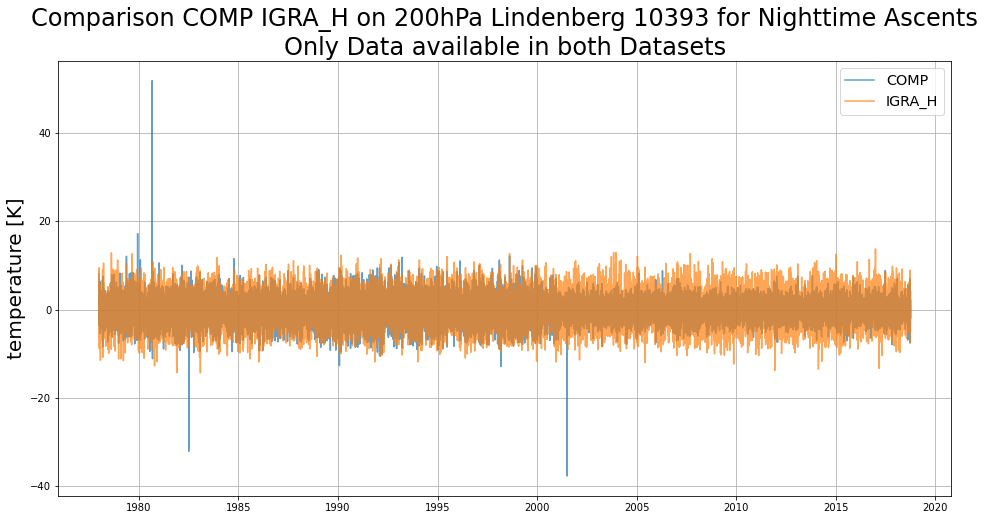

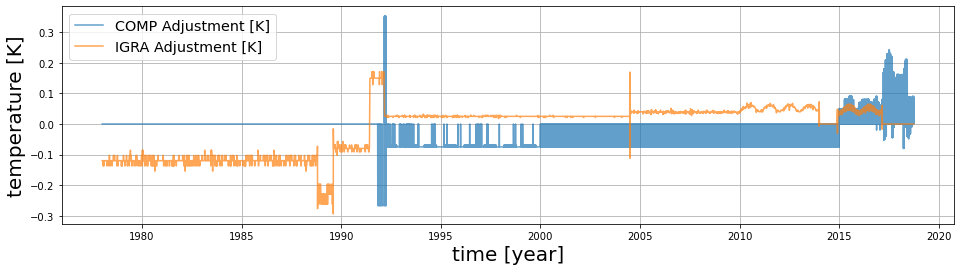

COMP Adjustment MEAN: -0.01653926175545721
COMP Adjustment MIN: -0.2668369
COMP Adjustment MAX: 0.35268520000000003
IGRA Adjustment MEAN: -0.015324106033412171
IGRA Adjustment MIN: -0.2942857142857065
IGRA Adjustment MAX: 0.17142857142860635


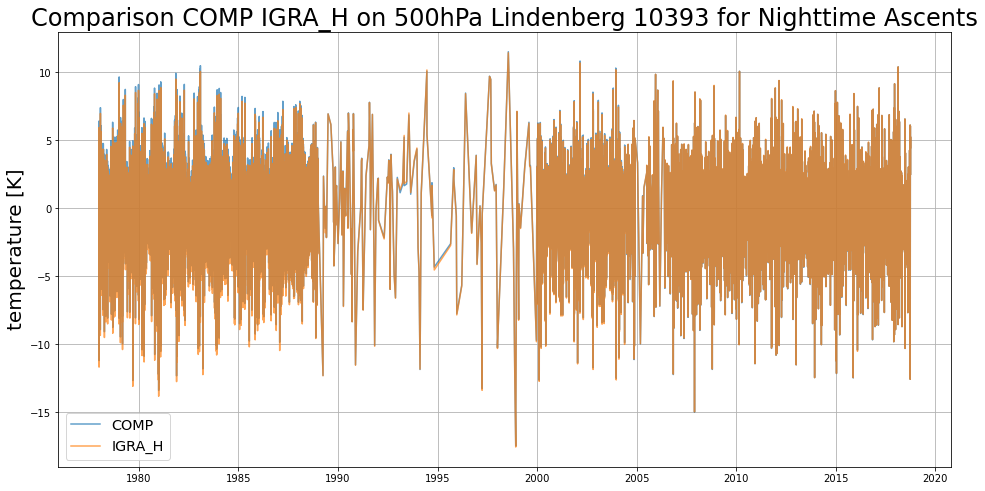

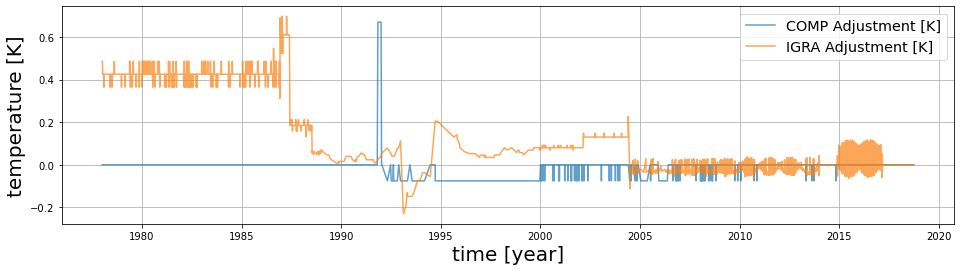

COMP Adjustment MEAN: -0.0008454638600329105
COMP Adjustment MIN: -0.07565009
COMP Adjustment MAX: 0.66927344
IGRA Adjustment MEAN: 0.1560951090338363
IGRA Adjustment MIN: -0.23071428571427077
IGRA Adjustment MAX: 0.6971428571428646


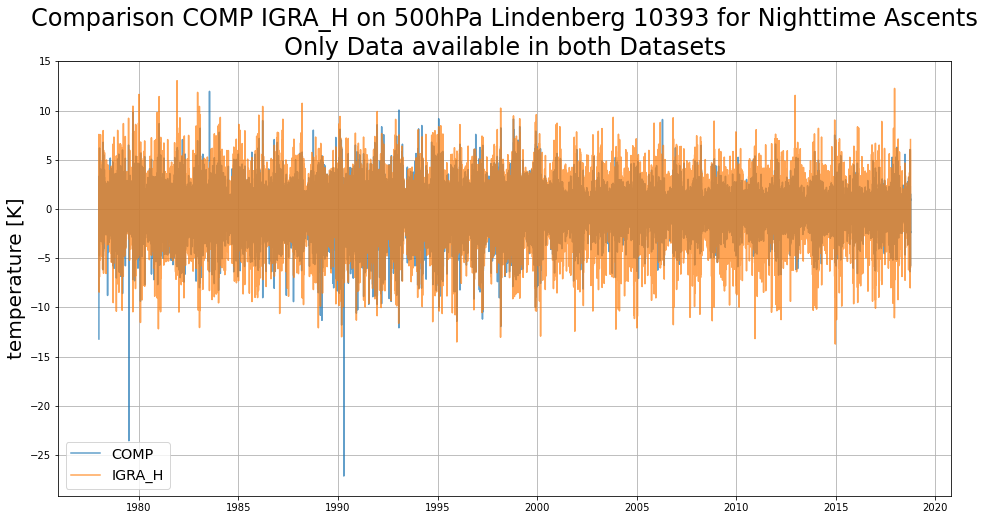

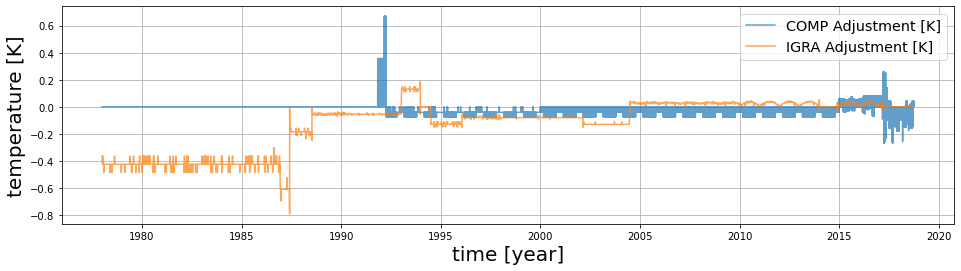

COMP Adjustment MEAN: -0.011851171058396054
COMP Adjustment MIN: -0.27077508
COMP Adjustment MAX: 0.6692735
IGRA Adjustment MEAN: -0.12465011385959628
IGRA Adjustment MIN: -0.7921428571428635
IGRA Adjustment MAX: 0.18571428571428328


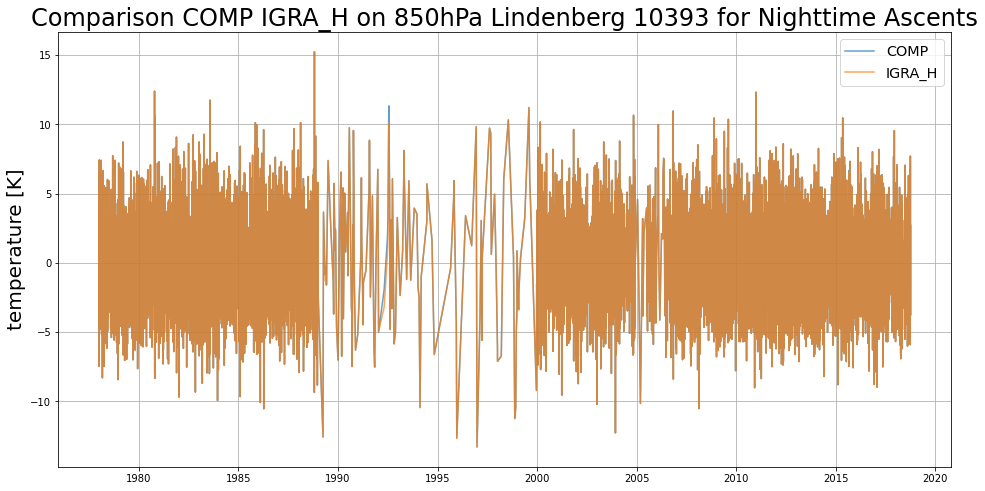

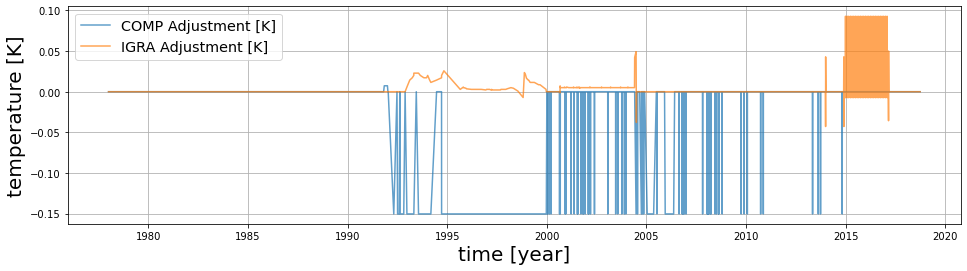

COMP Adjustment MEAN: -0.002063691848611783
COMP Adjustment MIN: -0.15038255
COMP Adjustment MAX: 0.0073034666
IGRA Adjustment MEAN: 0.0008257438604733123
IGRA Adjustment MIN: -0.042857142857201325
IGRA Adjustment MAX: 0.0928571428572127


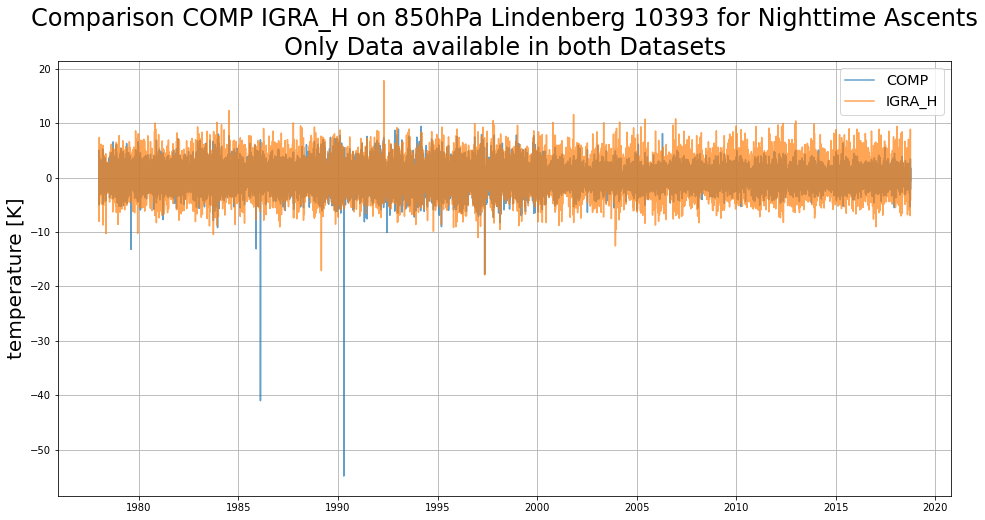

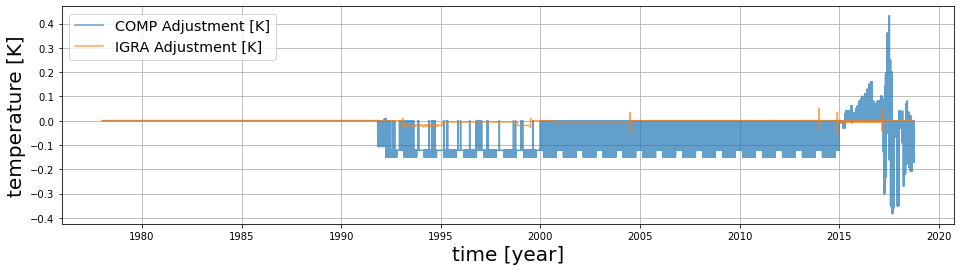

COMP Adjustment MEAN: -0.035021783674919586
COMP Adjustment MIN: -0.383943
COMP Adjustment MAX: 0.43000028
IGRA Adjustment MEAN: -0.0022539606571468354
IGRA Adjustment MIN: -0.050714285714320795
IGRA Adjustment MAX: 0.05000000000001137


In [17]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    a = igra_ma[i]
    a = a[a.report_timestamp.dt.hour == 12]
    b = igra_h_ma[i]
    b = b[b.report_timestamp.dt.hour == 12]
    c = comp_ma[i]
    c = c[c.time.dt.hour == 12]
    xax = np.asarray(c.time)    
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax1.plot(xax, np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(xax, np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    ax1.set(ylabel='temperature [K]', title='Comparison COMP IGRA_H on '+str(preslist[i])+'hPa '+loc+' for Nighttime Ascents')
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    ca = np.asarray(c.bias_estimate)
    ax1.plot(xax, ca, label = 'COMP Adjustment [K]', alpha=0.7)
    ia = np.asarray(a.air_temperature)-np.asarray(b.air_temperature)
    ax1.plot(xax, ia, label = 'IGRA Adjustment [K]', alpha=0.7)
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]')
    ax1.legend( loc='best')
    ax1.grid()
#     textstr = ('COMP Adjustment MEAN: ' + str(ca.mean()) + '\n' +'COMP Adjustment MIN: ' + str(ca.min()) + '\n' +'COMP Adjustment MAX: ' + str(ca.max()) + '\n' +'IGRA Adjustment MEAN: ' + str(ia.mean())+ '\n' +'IGRA Adjustment MIN: ' + str(ia.min())  + '\n' +'IGRA Adjustment MAX: ' + str(ia.max()))
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#     ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
    plt.show()
    plt.close(fig)
    
    print('COMP Adjustment MEAN: ' + str(ca.mean()))
    print('COMP Adjustment MIN: ' + str(ca.min()))
    print('COMP Adjustment MAX: ' + str(ca.max()))
    print('IGRA Adjustment MEAN: ' + str(ia.mean()))
    print('IGRA Adjustment MIN: ' + str(ia.min()))
    print('IGRA Adjustment MAX: ' + str(ia.max()))
    
    
    a = igra_o_ma[i]
    a = a[a.report_timestamp.dt.hour < 6].append(a[a.report_timestamp.dt.hour >= 18]).sort_values('report_timestamp')
    b = igrah_o_ma[i]
    b = b[b.report_timestamp.dt.hour < 6].append(b[b.report_timestamp.dt.hour >= 18]).sort_values('report_timestamp')
    c = comp_o_ma[i]
    c = c[c.time.dt.hour < 6].append(c[c.time.dt.hour >= 18]).sort_values('time')
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax1.plot(np.asarray(c.time), np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(np.asarray(b.report_timestamp), np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    ax1.set(ylabel='temperature [K]', title='Comparison COMP IGRA_H on '+str(preslist[i])+'hPa '+loc+' for Nighttime Ascents'+'\n'+'Only Data available in both Datasets')
    ax1.legend( loc='best')
    ax1.grid()
    plt.show()
    plt.close(fig)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    ca = np.asarray(c.bias_estimate)
    ax1.plot(np.asarray(c.time), ca, label = 'COMP Adjustment [K]', alpha=0.7)
    ia = np.asarray(a.air_temperature)-np.asarray(b.air_temperature)
    ax1.plot(np.asarray(a.report_timestamp), ia, label = 'IGRA Adjustment [K]', alpha=0.7)
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]')
    ax1.legend( loc='best')
    ax1.grid()
#     textstr = ('COMP Adjustment MEAN: ' + str(ca.mean()) + '\n' +'COMP Adjustment MIN: ' + str(ca.min()) + '\n' +'COMP Adjustment MAX: ' + str(ca.max()) + '\n' +'IGRA Adjustment MEAN: ' + str(ia.mean())+ '\n' +'IGRA Adjustment MIN: ' + str(ia.min())  + '\n' +'IGRA Adjustment MAX: ' + str(ia.max()))
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#     ax1.text(0.03, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
    plt.show()
    plt.close(fig)
    
    print('COMP Adjustment MEAN: ' + str(ca.mean()))
    print('COMP Adjustment MIN: ' + str(ca.min()))
    print('COMP Adjustment MAX: ' + str(ca.max()))
    print('IGRA Adjustment MEAN: ' + str(ia.mean()))
    print('IGRA Adjustment MIN: ' + str(ia.min()))
    print('IGRA Adjustment MAX: ' + str(ia.max()))

## Difference:

Finding the difference between the two data sets by subtracting them.

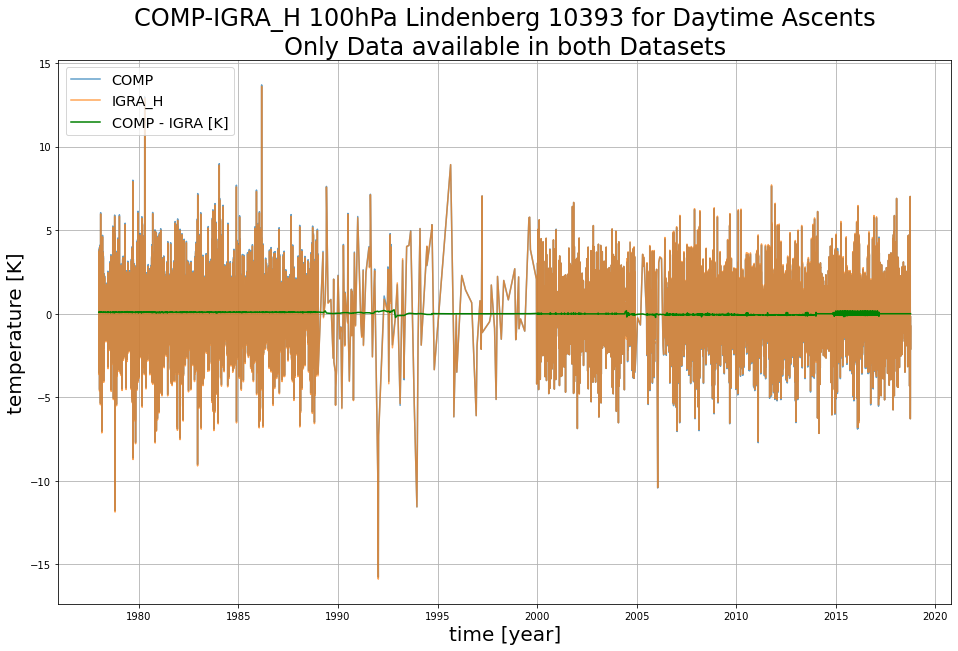

DIFF MEAN: 0.007539912399594419
DIFF MIN: -0.22785714285714675
DIFF MAX: 0.23642857142857565


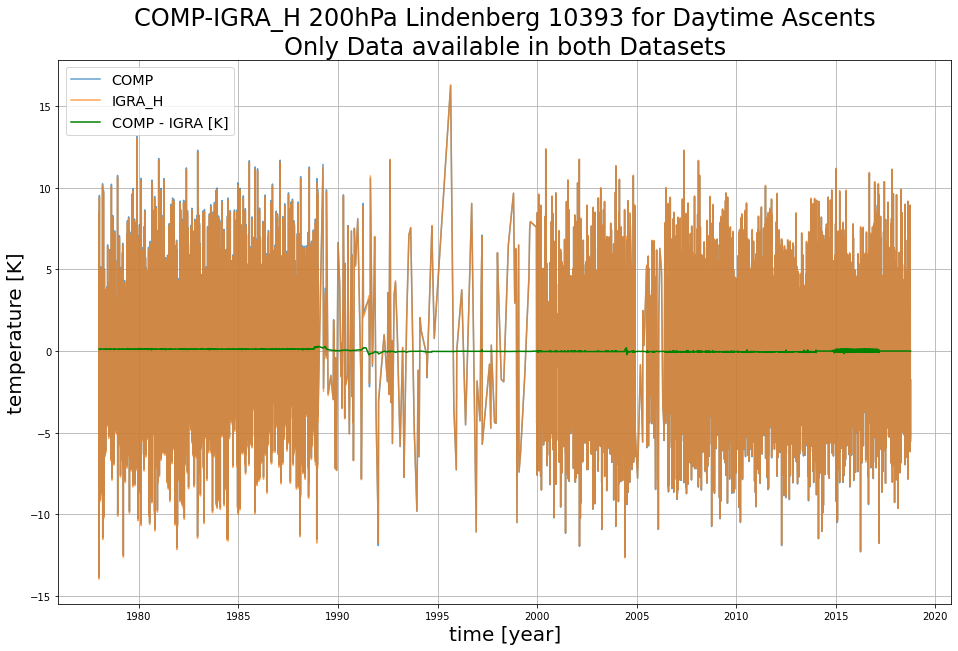

DIFF MEAN: 0.024609247392889066
DIFF MIN: -0.22857142857139934
DIFF MAX: 0.2957142857142969


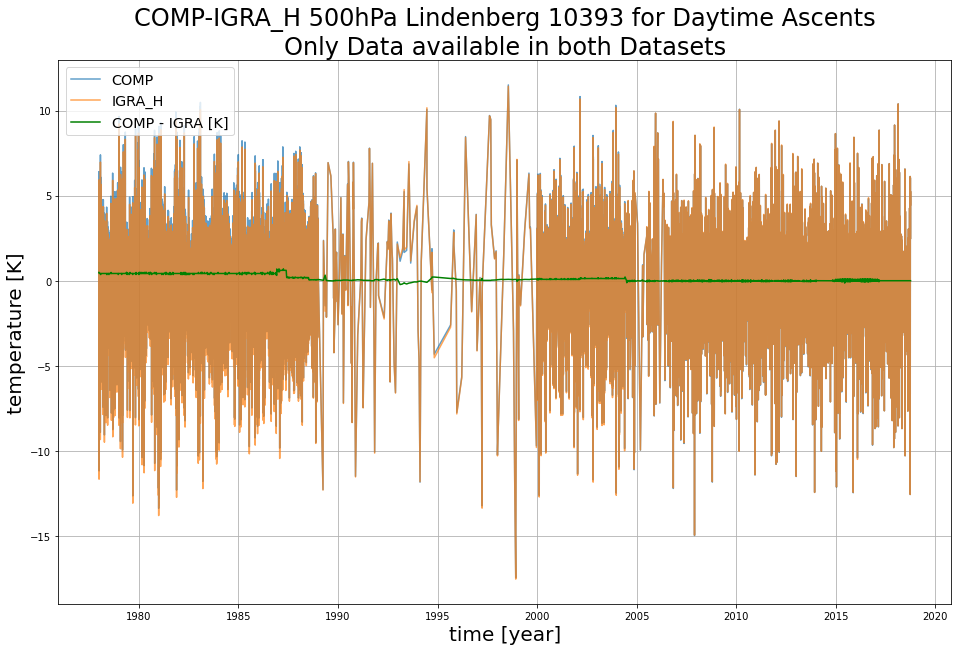

DIFF MEAN: 0.15607886112532235
DIFF MIN: -0.22714285714283733
DIFF MAX: 0.6971428571428646


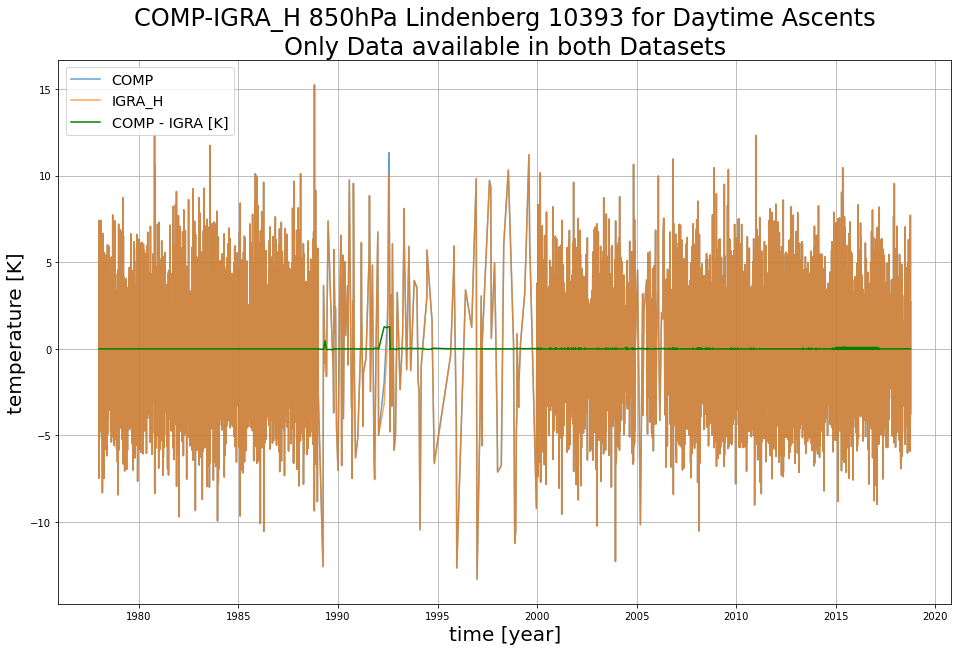

DIFF MEAN: 0.0014376235160793315
DIFF MIN: -0.04642857142863477
DIFF MAX: 1.2714285714286007


In [18]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    a = igra_ma[i]
    a = a[a.report_timestamp.dt.hour == 12]
    b = igra_h_ma[i]
    b = b[b.report_timestamp.dt.hour == 12]
    c = comp_ma[i]
    c = c[c.time.dt.hour == 12]
    xax = np.asarray(c.time)

    fig, (ax1) = plt.subplots(1, 1)

    ax1.plot(xax, np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(xax, np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    diff = np.asarray(c.ta)-np.asarray(b.air_temperature)
    ax1.plot(xax, diff, label = 'COMP - IGRA [K]', c='green')
    ax1.grid()
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]', title='COMP-IGRA_H '+str(preslist[i])+'hPa '+loc+' for Daytime Ascents'+'\n'+'Only Data available in both Datasets')
    ax1.legend( loc='upper left')
    plt.show()
    plt.close(fig)
    print('DIFF MEAN: ' + str(diff.mean()))
    print('DIFF MIN: ' + str(diff.min()))
    print('DIFF MAX: ' + str(diff.max()))

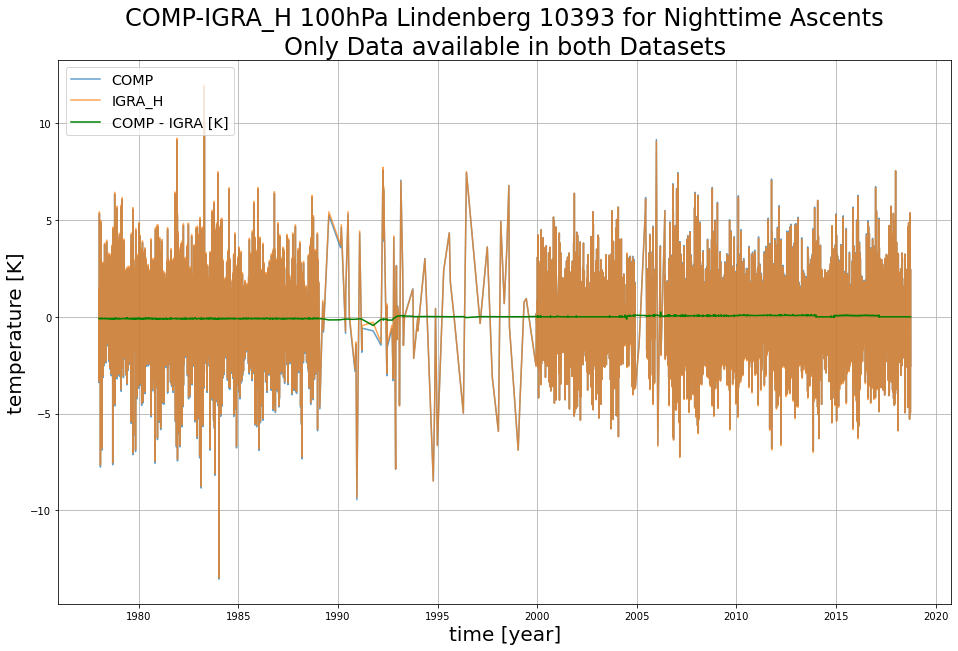

DIFF MEAN: -0.007648379412401017
DIFF MIN: -0.4471428571428362
DIFF MAX: 0.2521428571428146


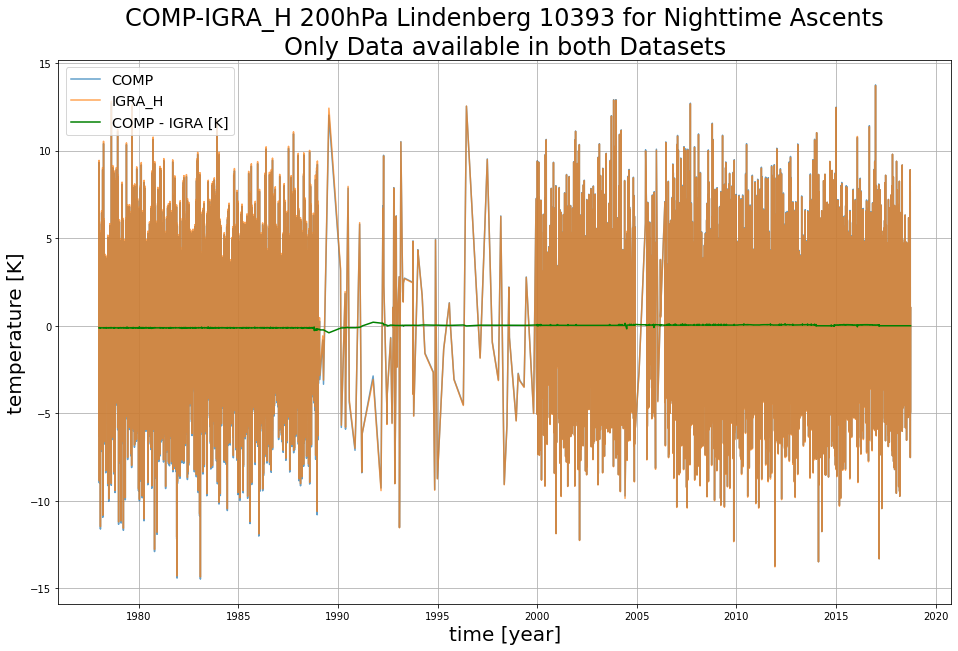

DIFF MEAN: -0.024723533945211994
DIFF MIN: -0.4014285714285961
DIFF MAX: 0.20214285714286007


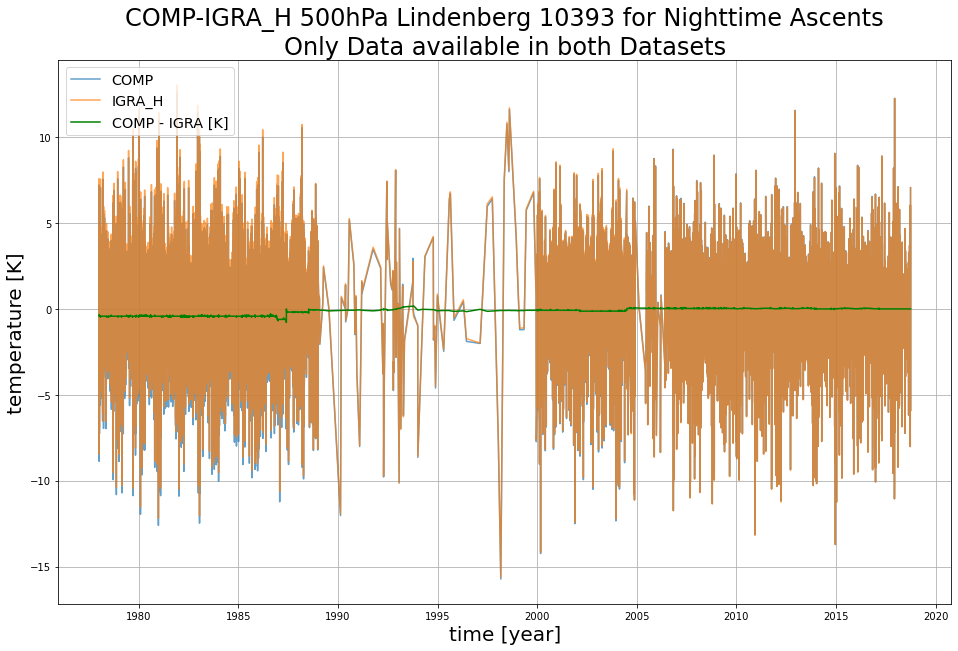

DIFF MEAN: -0.15641623464833265
DIFF MIN: -0.7921428571428635
DIFF MAX: 0.17071428571429692


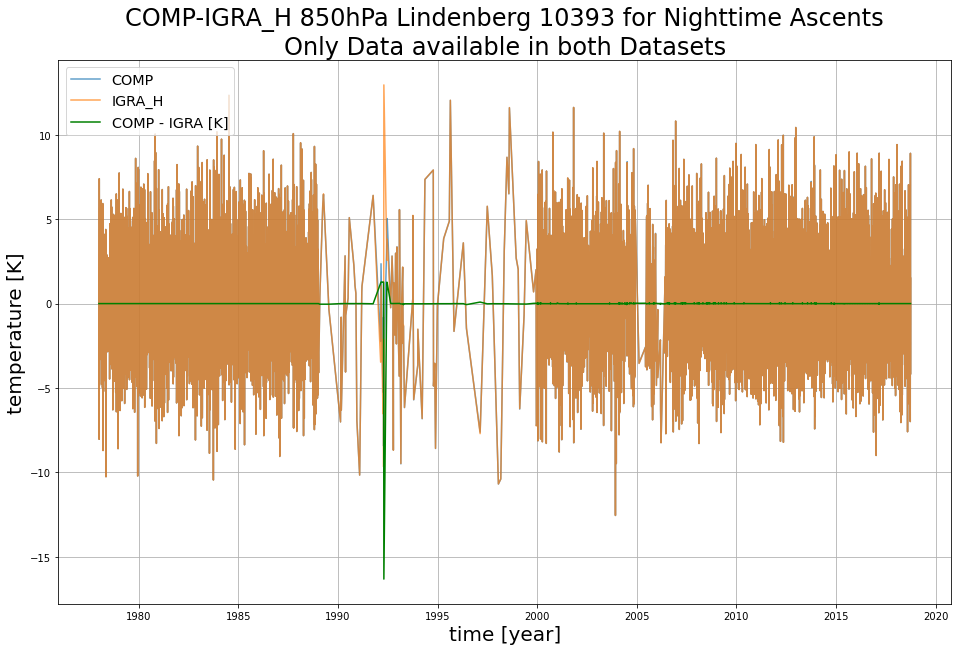

DIFF MEAN: -0.0014412485971982154
DIFF MIN: -16.32499999999999
DIFF MAX: 1.2785714285713539


In [19]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    a = igra_ma[i]
    a = a[a.report_timestamp.dt.hour == 0]
    b = igra_h_ma[i]
    b = b[b.report_timestamp.dt.hour == 0]
    c = comp_ma[i]
    c = c[c.time.dt.hour == 0]
    xax = np.asarray(c.time)

    fig, (ax1) = plt.subplots(1, 1)

    ax1.plot(xax, np.asarray(c.ta), label = 'COMP', alpha=0.7)
    ax1.plot(xax, np.asarray(b.air_temperature), label = 'IGRA_H', alpha=0.7)
    diff = np.asarray(c.ta)-np.asarray(b.air_temperature)
    ax1.plot(xax, diff, label = 'COMP - IGRA [K]', c='green')
    ax1.grid()
    ax1.set(xlabel ='time [year]', ylabel='temperature [K]', title='COMP-IGRA_H '+str(preslist[i])+'hPa '+loc+' for Nighttime Ascents'+'\n'+'Only Data available in both Datasets')
    ax1.legend( loc='upper left')
    plt.show()
    plt.close(fig)
    print('DIFF MEAN: ' + str(diff.mean()))
    print('DIFF MIN: ' + str(diff.min()))
    print('DIFF MAX: ' + str(diff.max()))

## Distribution of Adjustments

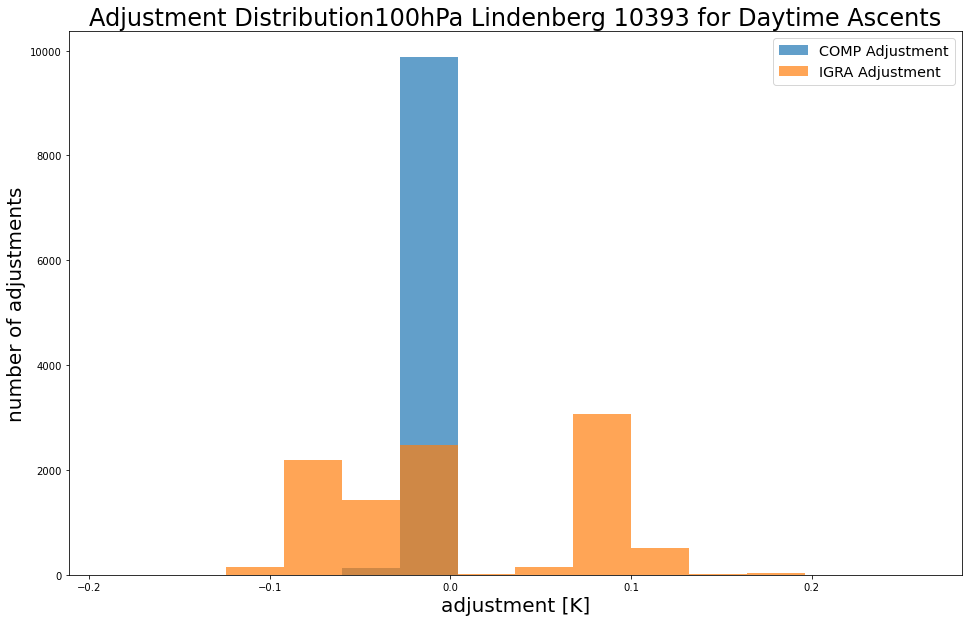

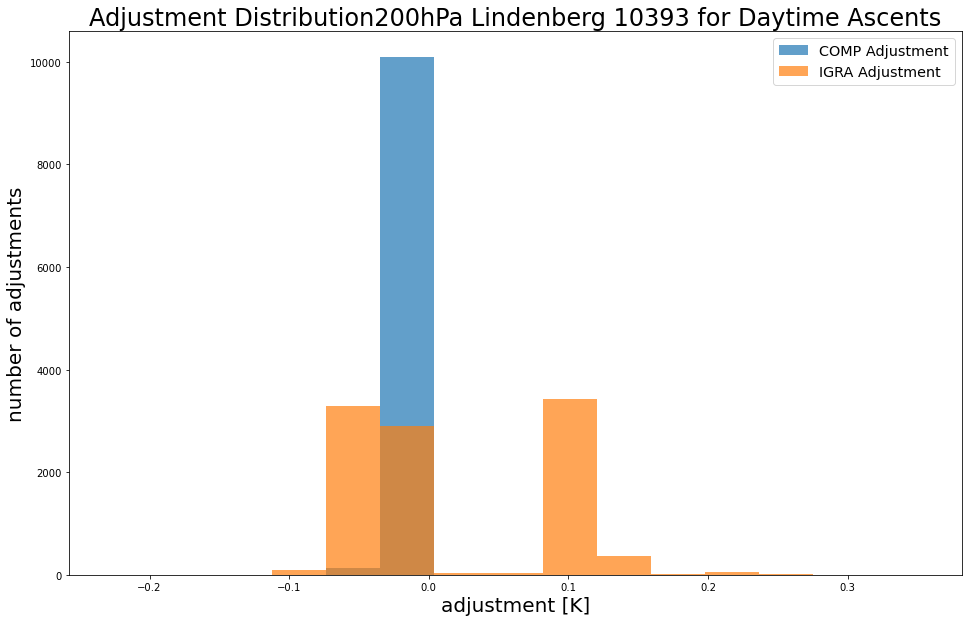

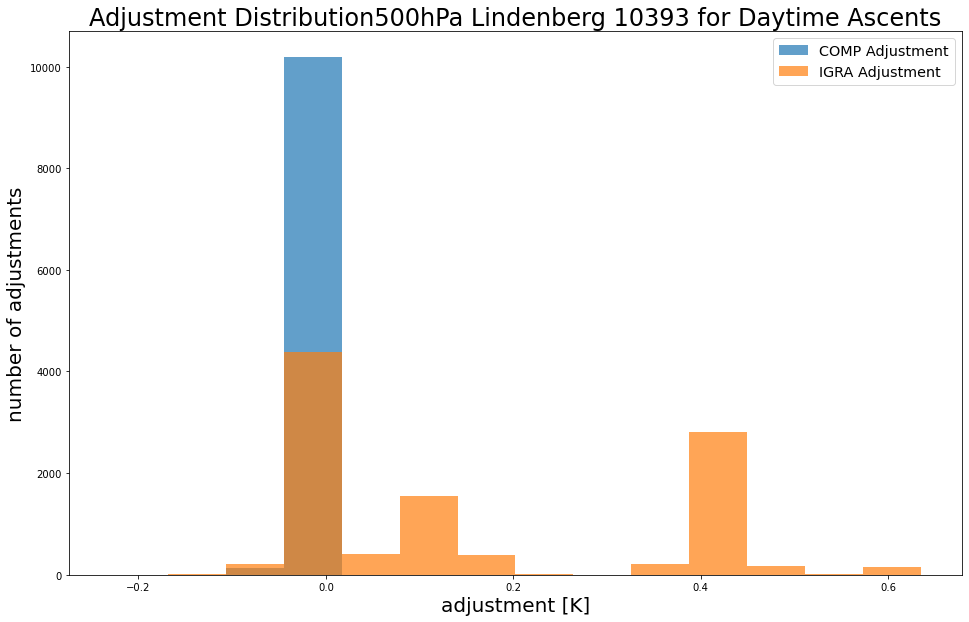

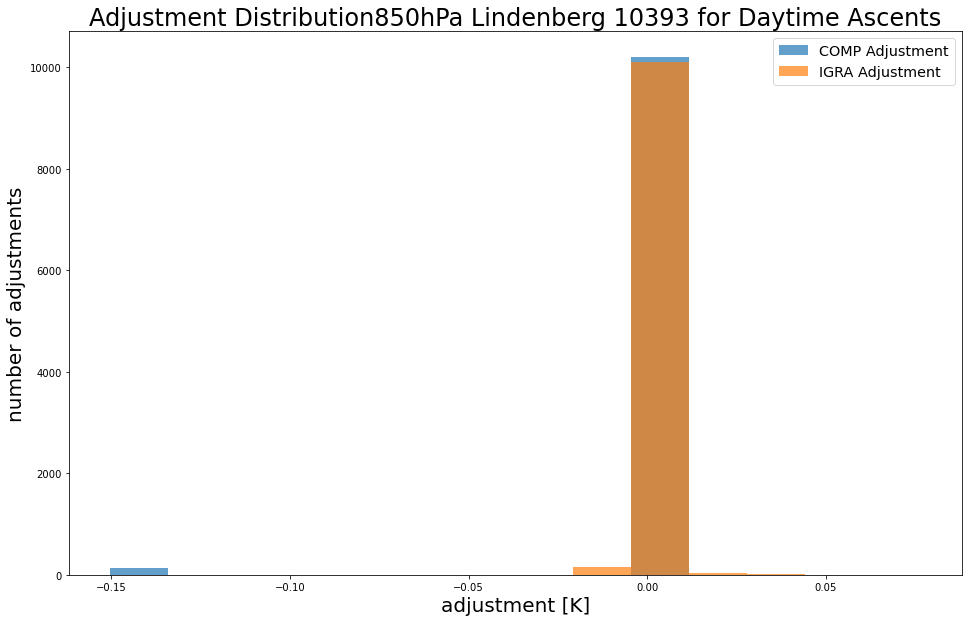

In [20]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    a = igra_ma[i]
    a = a[a.report_timestamp.dt.hour == 12]
    b = igra_h_ma[i]
    b = b[b.report_timestamp.dt.hour == 12]
    c = comp_ma[i]
    c = c[c.time.dt.hour == 12]
    xax = np.asarray(c.time)

    fig, (ax1) = plt.subplots(1, 1)

    ca = np.asarray(c.bias_estimate)
    ia = np.asarray(a.air_temperature)-np.asarray(b.air_temperature)
    if ia.min() < ca.min(): binmin = ia.min()
    else: binmin = ca.min()
    if ia.max() > ca.max(): binmax = ia.max()
    else: binmax = ca.max()
    bins = np.arange(binmin, binmax, (binmax-binmin)/15.)
    
    ax1.hist(ca, bins=bins, label='COMP Adjustment', alpha=0.7)
    ax1.hist(ia, bins=bins, label='IGRA Adjustment', alpha=0.7)
    
    ax1.set(xlabel ='adjustment [K]', ylabel='number of adjustments', title='Adjustment Distribution'+str(preslist[i])+'hPa '+loc+' for Daytime Ascents')
    ax1.legend( loc='best')
    plt.show()
    plt.close(fig)

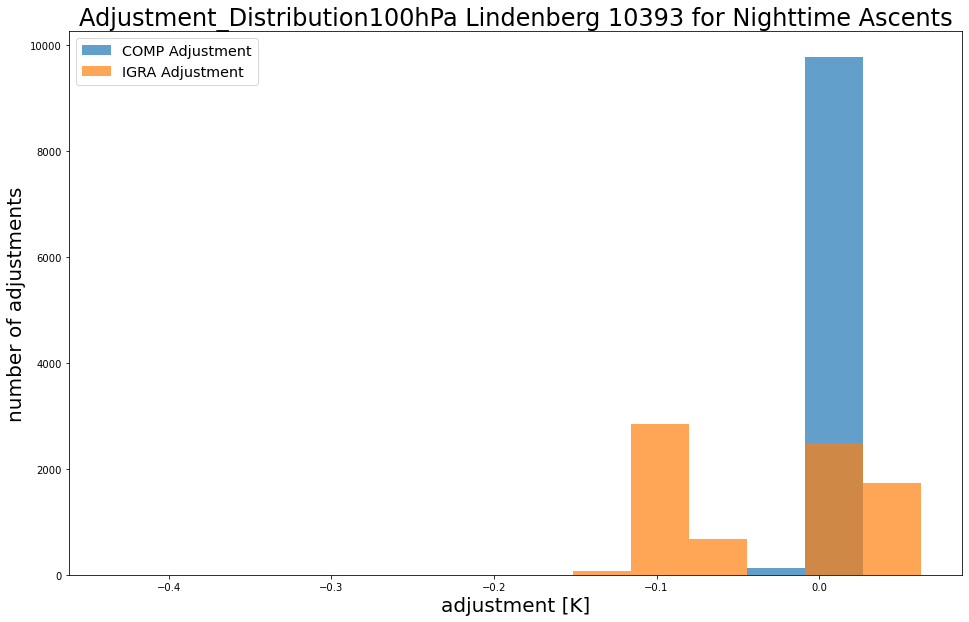

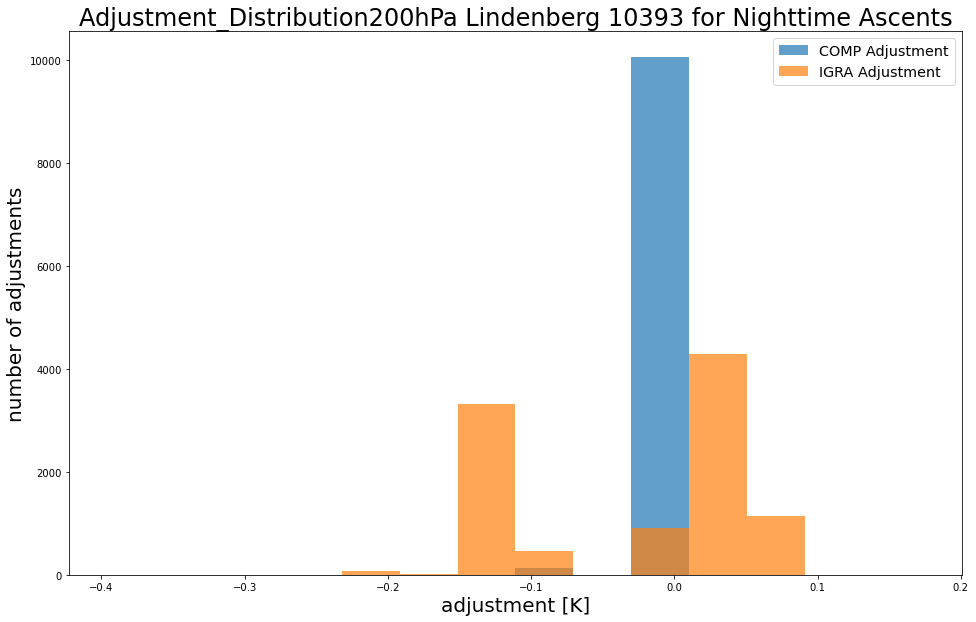

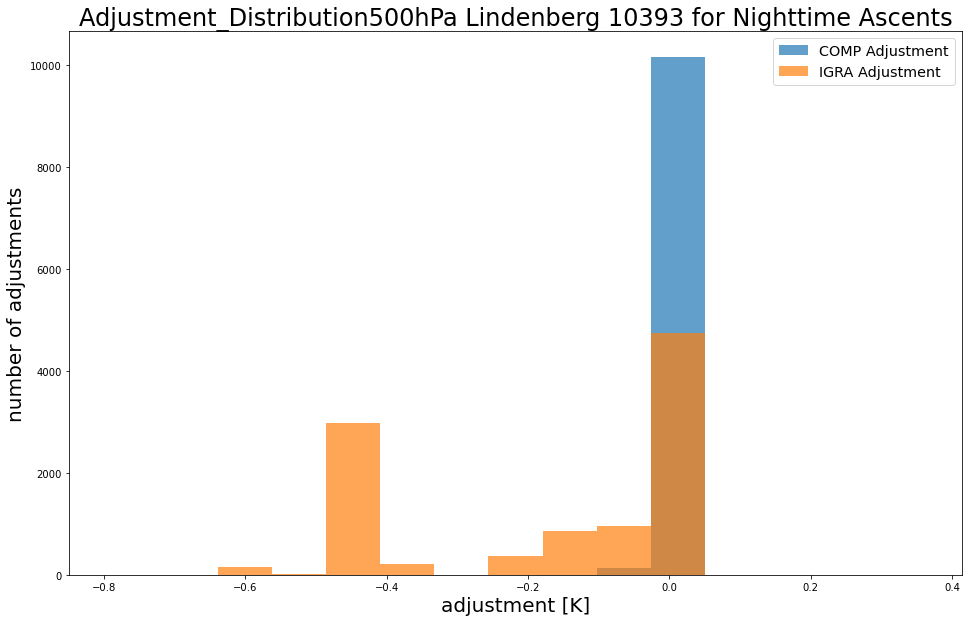

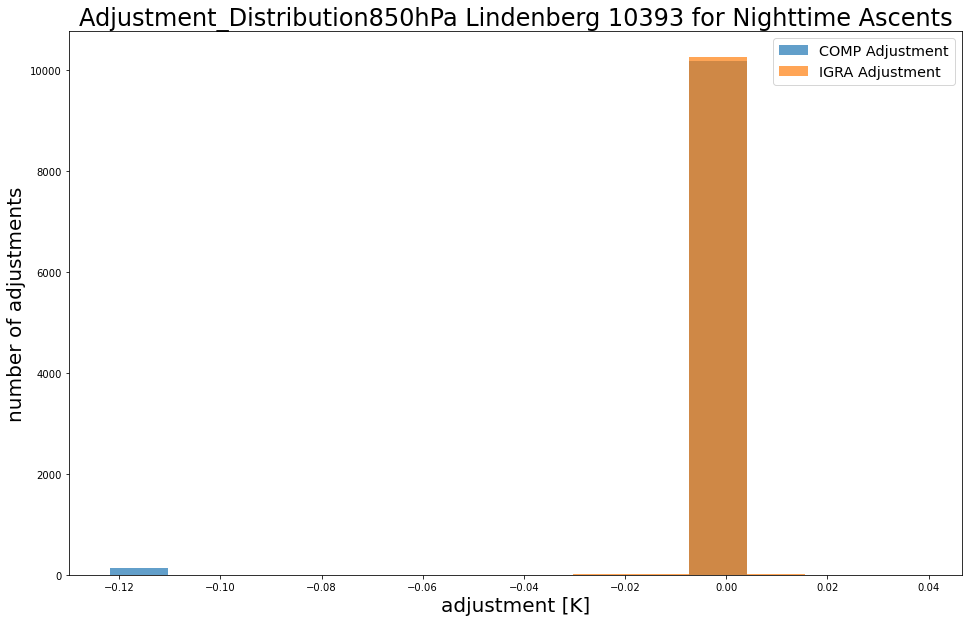

In [21]:
preslist = [100, 200, 500, 850,]
for i in range(len(preslist)):
    a = igra_ma[i]
    a = a[a.report_timestamp.dt.hour == 0]
    b = igra_h_ma[i]
    b = b[b.report_timestamp.dt.hour == 0]
    c = comp_ma[i]
    c = c[c.time.dt.hour == 0]
    xax = np.asarray(c.time)

    fig, (ax1) = plt.subplots(1, 1)

    ca = np.asarray(c.bias_estimate)
    ia = np.asarray(a.air_temperature)-np.asarray(b.air_temperature)
    if ia.min() < ca.min(): binmin = ia.min()
    else: binmin = ca.min()
    if ia.max() > ca.max(): binmax = ia.max()
    else: binmax = ca.max()
    bins = np.arange(binmin, binmax, (binmax-binmin)/15.)
    
    ax1.hist(ca, bins=bins, label='COMP Adjustment', alpha=0.7)
    ax1.hist(ia, bins=bins, label='IGRA Adjustment', alpha=0.7)

    ax1.set(xlabel ='adjustment [K]', ylabel='number of adjustments', title='Adjustment_Distribution'+str(preslist[i])+'hPa '+loc+' for Nighttime Ascents')
    ax1.legend( loc='best')
    plt.show()
    plt.close(fig)